<a href="https://colab.research.google.com/github/Naiduramisetti/HSI---Silver-Identification-and-Depth-Identification/blob/main/Hsi_Silver_identifiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spectral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 3.4 MB/s eta 0:00:00


<ipython-input-8-7e28380940f5>:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  calibrated_data = raw_data - dark_data
<ipython-input-8-7e28380940f5>:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  normalized_white = white_data - dark_data


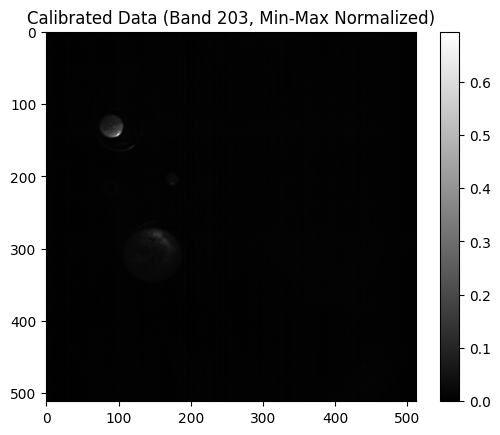

In [ ]:
import numpy as np

from spectral import envi
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Load the hyperspectral image and reference images
SCraw = envi.open('1872.hdr', '1872.raw')

# Open the white and dark reference images
white_reference = envi.open('WHITEREF_1872.hdr', image='WHITEREF_1872.raw')
dark_reference = envi.open('DARKREF_1872.hdr', image='DARKREF_1872.raw')

# Read the raw data and references as NumPy arrays
raw_data = SCraw.load()
white_data = white_reference.load()
dark_data = dark_reference.load()

# Subtract dark reference from raw image
calibrated_data = raw_data - dark_data

# Subtract dark reference from white reference
normalized_white = white_data - dark_data

# Divide calibrated image by normalized white reference
calibrated_data /= normalized_white

# Apply Savitzky-Golay filter for smoothing along the spectral dimension
# Ensure the calibrated_data has shape (height, width, bands)
bands = calibrated_data.shape[-1]
for i in range(calibrated_data.shape[0]):  # Iterate over height
    for j in range(calibrated_data.shape[1]):  # Iterate over width
        calibrated_data[i, j, :] = savgol_filter(
            calibrated_data[i, j, :], window_length=11, polyorder=2
        )

# Apply Min-Max normalization (0 to 1)
calibrated_data_min = np.min(calibrated_data)
calibrated_data_max = np.max(calibrated_data)
calibrated_data = (calibrated_data - calibrated_data_min) / (calibrated_data_max - calibrated_data_min)

# Save a single band as a visualization example
plt.imshow(calibrated_data[:, :, 203], cmap='gray')  # Example for band 50
plt.colorbar()
plt.title("Calibrated Data (Band 203, Min-Max Normalized)")
plt.show()


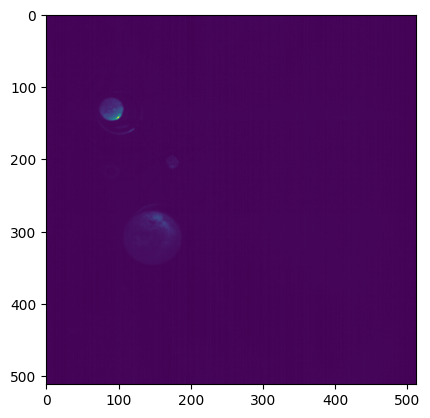

In [ ]:
plt.imshow(calibrated_data[:,:,203])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Assuming calibrated_data is your hyperspectral dataset
# Extract the 203rd band
band_203 = calibrated_data[:, :, 203]

# Normalize data for better visualization (if necessary)
band_203_normalized = (band_203 - band_203.min()) / (band_203.max() - band_203.min())

# Save as PNG
plt.imsave('band_203.png', band_203_normalized, cmap=cm.gray)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming calibrated_data is your hyperspectral dataset
# Select bands for Red, Green, and Blue channels (adjust these indices as needed)
# Hyperspectral datasets vary, but common bands used for RGB approximation:
red_band = calibrated_data[:, :, 60]  # Approximate red band
green_band = calibrated_data[:, :, 30]  # Approximate green band
blue_band = calibrated_data[:, :, 10]  # Approximate blue band

# Stack the bands to form an RGB image
rgb_image = np.dstack((red_band, green_band, blue_band))

# Normalize each channel to the 0-1 range for visualization
rgb_image_normalized = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Save the RGB image
plt.imsave('rgb_image.png', rgb_image_normalized)



In [ ]:
import numpy as np
import json
import cv2

# Load JSON file with labels and annotations
with open('/content/labels_my-project-name_2024-11-13-05-08-27.json', 'r') as file:
    data = json.load(file)

# Initialize a blank mask with the same spatial dimensions as the hyperspectral image
height, width = 512, 512
mask = np.zeros((height, width), dtype=np.uint8)

# Define category to label mapping
label_map = {'gold': 1, 'silver': 2, 'copper': 3}

# Loop through annotations and apply label values to the mask
for annotation in data['annotations']:
    category_id = annotation['category_id']
    segmentation = annotation['segmentation'][0]  # Assumes one segmentation per annotation

    # Reshape segmentation list into (x, y) coordinates
    points = np.array(segmentation).reshape(-1, 2)
    points = points.astype(np.int32)  # Convert to integer coordinates

    # Draw filled polygon on mask for each label
    cv2.fillPoly(mask, [points], label_map[data['categories'][category_id - 1]['name']])

# Save mask as a PNG
cv2.imwrite('label_mask.png', mask)


True

In [ ]:
import numpy as np
import cv2

# Load the saved label mask
mask = cv2.imread('label_mask.png', cv2.IMREAD_GRAYSCALE)

# Define label-to-color mapping
label_colors = {
    0: (0, 0, 0),        # Background - Black
    1: (255, 0, 0),      # Gold - Red
    2: (0, 255, 0),      # Silver - Green
    3: (0, 0, 255)       # Copper - Blue
}

# Create a blank RGB image with the same dimensions as the mask
height, width = mask.shape
colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

# Apply the colors to the mask based on label values
for label, color in label_colors.items():
    colored_mask[mask == label] = color

# Save the colored mask as a PNG image
cv2.imwrite('colored_label_mask.png', colored_mask)

# Optionally display the image (requires GUI support)
# cv2.imshow('Colored Label Mask', colored_mask)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


True

In [ ]:
import numpy as np
import cv2

# Load the saved label mask
mask = cv2.imread('label_mask.png', cv2.IMREAD_GRAYSCALE)

# Define label-to-color mapping (background is white)
label_colors = {
    0: (255, 255, 255),  # Background - White
    1: (255, 0, 0),      # Gold - Red
    2: (0, 255, 0),      # Silver - Green
    3: (0, 0, 255)       # Copper - Blue
}

# Create a blank RGB image with the same dimensions as the mask
height, width = mask.shape
colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

# Apply the colors to the mask based on label values
for label, color in label_colors.items():
    colored_mask[mask == label] = color

# Save the colored mask as a PNG image
cv2.imwrite('colored_label_mask_white_bg.png', colored_mask)

# Optionally display the image (requires GUI support)
# cv2.imshow('Colored Label Mask with White Background', colored_mask)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


True

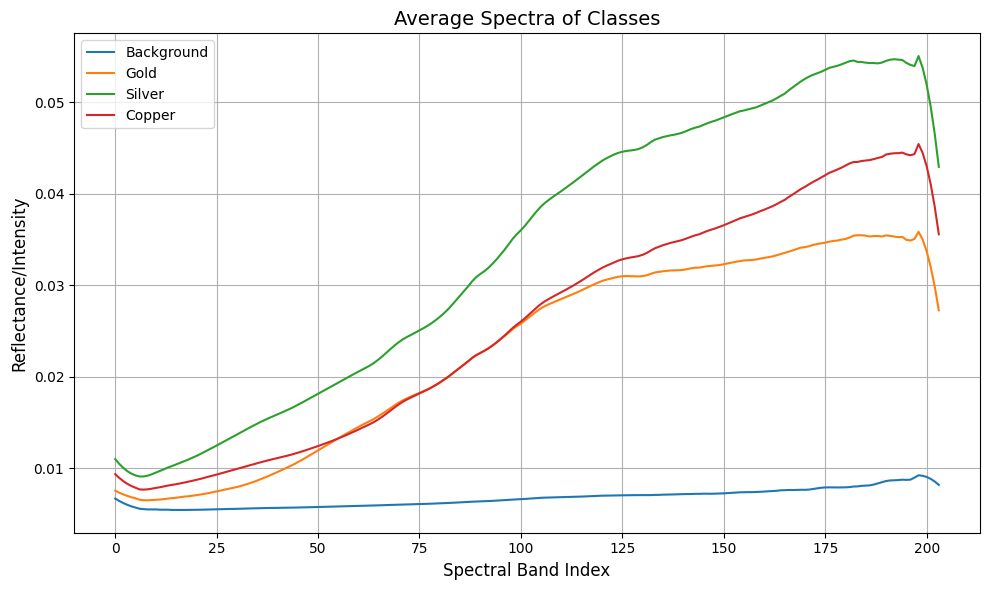

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the hyperspectral data (replace with actual data loading)
#calibrated_data2 = np.random.rand(512, 512, 204)  # Example: 512x512 image with 204 spectral bands

# Load the label mask
mask = cv2.imread('label_mask.png', cv2.IMREAD_GRAYSCALE)

# Define the labels
labels = {
    0: 'Background',
    1: 'Gold',
    2: 'Silver',
    3: 'Copper'
}

# Initialize a dictionary to store average spectra for each class
average_spectra1 = {}

# Loop through each class and calculate the average spectra
for label in labels.keys():
    # Extract the pixels corresponding to the current label
    class_pixels = calibrated_data[mask == label]

    if class_pixels.size > 0:  # Ensure there are pixels for this class
        # Calculate the mean spectrum for the class
        avg_spectrum = np.mean(class_pixels, axis=0)
        average_spectra1[label] = avg_spectrum
    else:
        average_spectra1[label] = None  # Handle empty classes gracefully

# Plot the average spectra
plt.figure(figsize=(10, 6))
for label, spectrum in average_spectra1.items():
    if spectrum is not None:
        plt.plot(spectrum, label=labels[label])  # Plot spectrum with corresponding label

# Customize the plot
plt.title("Average Spectra of Classes", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Reflectance/Intensity", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


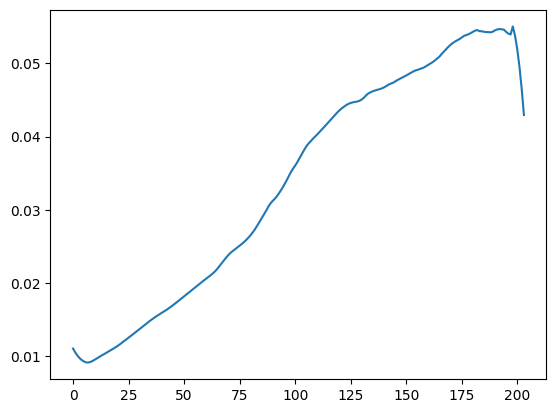

In [ ]:
plt.plot(average_spectra1.get(2))

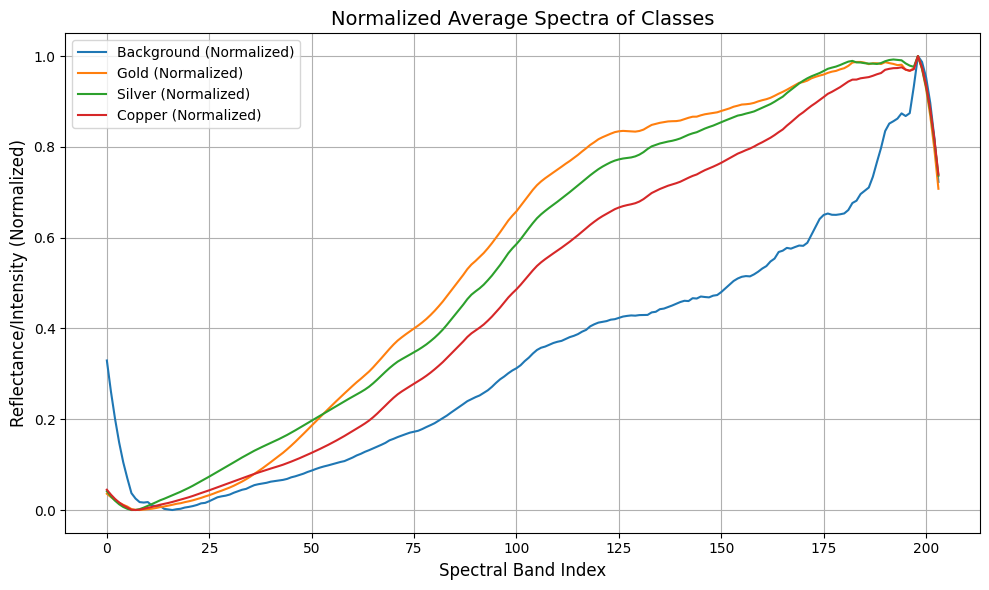

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the hyperspectral data (replace with actual data loading)
# calibrated_data is assumed to be available
mask = cv2.imread('label_mask.png', cv2.IMREAD_GRAYSCALE)

# Define the labels
labels = {
    0: 'Background',
    1: 'Gold',
    2: 'Silver',
    3: 'Copper'
}

# Initialize a dictionary to store average spectra for each class
average_spectra1 = {}

# Loop through each class and calculate the average spectra
for label in labels.keys():
    # Extract the pixels corresponding to the current label
    class_pixels = calibrated_data[mask == label]

    if class_pixels.size > 0:  # Ensure there are pixels for this class
        # Calculate the mean spectrum for the class
        avg_spectrum = np.mean(class_pixels, axis=0)
        average_spectra1[label] = avg_spectrum
    else:
        average_spectra1[label] = None  # Handle empty classes gracefully

# Normalize each spectrum (0 to 1)
def normalize_spectrum(spectrum):
    """Normalize a spectrum to the range [0, 1]."""
    spectrum_min = np.min(spectrum)
    spectrum_max = np.max(spectrum)
    return (spectrum - spectrum_min) / (spectrum_max - spectrum_min)

# Apply normalization to average_spectra1
normalized_spectra1 = {
    label: normalize_spectrum(spectrum) if spectrum is not None else None
    for label, spectrum in average_spectra1.items()
}

# Plot the normalized spectra
plt.figure(figsize=(10, 6))
for label, spectrum in normalized_spectra1.items():
    if spectrum is not None:
        plt.plot(spectrum, label=f"{labels[label]} (Normalized)")

# Customize the plot
plt.title("Normalized Average Spectra of Classes", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Reflectance/Intensity (Normalized)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from spectral import *
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assume `calibrated_data` (H x W x Bands) and `mask` (H x W) are loaded
# `mask` contains ground truth labels:
# 0 = Background, 1 = Gold, 2 = Silver, 3 = Copper

# 1. Spectral Angle Mapper (SAM)
def spectral_angle_mapper(image, target_spectrum):
    H, W, B = image.shape
    target_norm = np.linalg.norm(target_spectrum)
    sam_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel_spectrum = image[i, j, :]
            pixel_norm = np.linalg.norm(pixel_spectrum)
            angle = np.arccos(
                np.dot(pixel_spectrum, target_spectrum) / (pixel_norm * target_norm + 1e-8)
            )
            sam_map[i, j] = angle
    return sam_map

# 2. Adaptive Cosine Estimator (ACE)
def adaptive_cosine_estimator(image, target_spectrum):
    H, W, B = image.shape
    target_cov = np.cov(image.reshape(-1, B), rowvar=False)
    target_cov_inv = np.linalg.inv(target_cov + 1e-8 * np.eye(B))
    target_spectrum = target_spectrum.reshape(-1, 1)
    ace_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel_spectrum = image[i, j, :].reshape(-1, 1)
            numerator = np.dot(target_spectrum.T, np.dot(target_cov_inv, pixel_spectrum))
            denominator = (
                np.sqrt(np.dot(target_spectrum.T, np.dot(target_cov_inv, target_spectrum)))
                * np.sqrt(np.dot(pixel_spectrum.T, np.dot(target_cov_inv, pixel_spectrum)))
            )
            ace_map[i, j] = (numerator / (denominator + 1e-8)).item()
    return ace_map

# 3. RX Anomaly Detection
def rx_anomaly_detection(image):
    H, W, B = image.shape
    image_flat = image.reshape(-1, B)
    mean_vector = np.mean(image_flat, axis=0)
    cov_matrix = np.cov(image_flat, rowvar=False)
    cov_inv = np.linalg.inv(cov_matrix + 1e-8 * np.eye(B))
    rx_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel = image[i, j, :]
            diff = pixel - mean_vector
            rx_map[i, j] = np.dot(diff.T, np.dot(cov_inv, diff))
    return rx_map

# Performance Metrics
def calculate_metrics(binary_result, ground_truth, average='macro'):
    binary_result_flat = binary_result.flatten()
    ground_truth_flat = ground_truth.flatten()

    precision = precision_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    recall = recall_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    f1 = f1_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    accuracy = accuracy_score(ground_truth_flat, binary_result_flat)

    return precision, recall, f1, accuracy

# Detect and evaluate for each target class
labels = {1: 'Gold', 2: 'Silver', 3: 'Copper'}
results = {}

for label, name in labels.items():
    print(f"\nProcessing {name} (Label {label})")
    target_spectrum = np.mean(calibrated_data[mask == label], axis=0)

    # Detection maps
    sam_result = spectral_angle_mapper(calibrated_data, target_spectrum)
    ace_result = adaptive_cosine_estimator(calibrated_data, target_spectrum)
    rx_result = rx_anomaly_detection(calibrated_data)

    # Convert to binary maps for the current target
    sam_binary = (sam_result < np.percentile(sam_result[mask == label], 5)).astype(int)  # Smallest 5% angles
    ace_binary = (ace_result > np.percentile(ace_result[mask == label], 95)).astype(int)  # Top 5% ACE scores
    rx_binary = (rx_result > np.percentile(rx_result[mask == label], 95)).astype(int)  # Top 5% anomalies

    # Evaluate performance
    sam_metrics = calculate_metrics(sam_binary, (mask == label).astype(int), average='binary')
    ace_metrics = calculate_metrics(ace_binary, (mask == label).astype(int), average='binary')
    rx_metrics = calculate_metrics(rx_binary, (mask == label).astype(int), average='binary')

    # Store results
    results[name] = {
        "SAM Metrics": sam_metrics,
        "ACE Metrics": ace_metrics,
        "RX Metrics": rx_metrics,
    }

# Display Results
for target, metrics in results.items():
    print(f"\nResults for {target}:")
    for method, values in metrics.items():
        print(f"  {method}: Precision={values[0]:.4f}, Recall={values[1]:.4f}, F1-Score={values[2]:.4f}, Accuracy={values[3]:.4f}")



Processing Gold (Label 1)

Processing Silver (Label 2)

Processing Copper (Label 3)

Results for Gold:
  SAM Metrics: Precision=1.0000, Recall=0.0526, F1-Score=0.1000, Accuracy=0.9991
  ACE Metrics: Precision=1.0000, Recall=0.0526, F1-Score=0.1000, Accuracy=0.9991
  RX Metrics: Precision=0.0379, Recall=0.0526, F1-Score=0.0441, Accuracy=0.9978

Results for Silver:
  SAM Metrics: Precision=0.1146, Recall=0.0502, F1-Score=0.0698, Accuracy=0.9843
  ACE Metrics: Precision=0.0050, Recall=0.0502, F1-Score=0.0091, Accuracy=0.8718
  RX Metrics: Precision=0.9809, Recall=0.0502, F1-Score=0.0955, Accuracy=0.9889

Results for Copper:
  SAM Metrics: Precision=0.9960, Recall=0.0501, F1-Score=0.0954, Accuracy=0.9820
  ACE Metrics: Precision=0.0061, Recall=0.0501, F1-Score=0.0108, Accuracy=0.8261
  RX Metrics: Precision=0.2596, Recall=0.0501, F1-Score=0.0840, Accuracy=0.9793



Processing Gold (Label 1)
Visualizing results for Gold (Label 1):


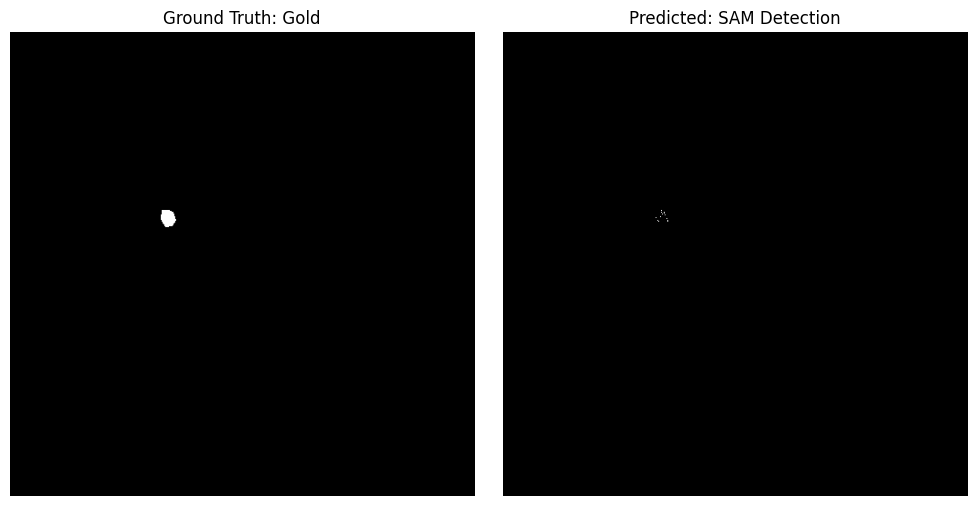

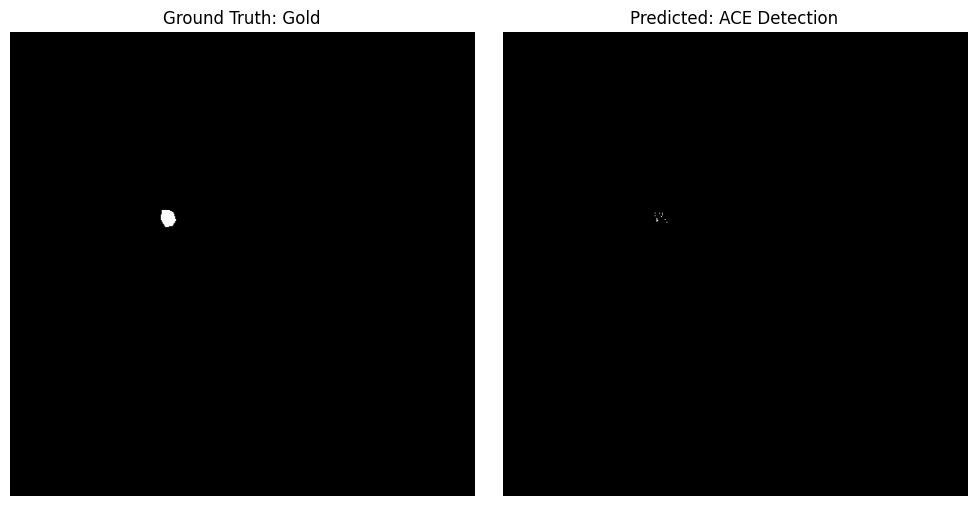

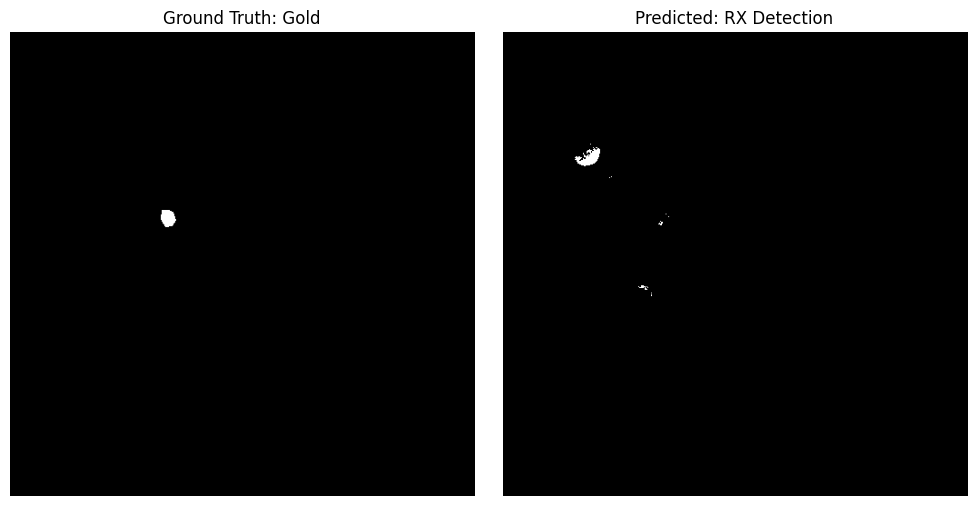


Processing Silver (Label 2)
Visualizing results for Silver (Label 2):


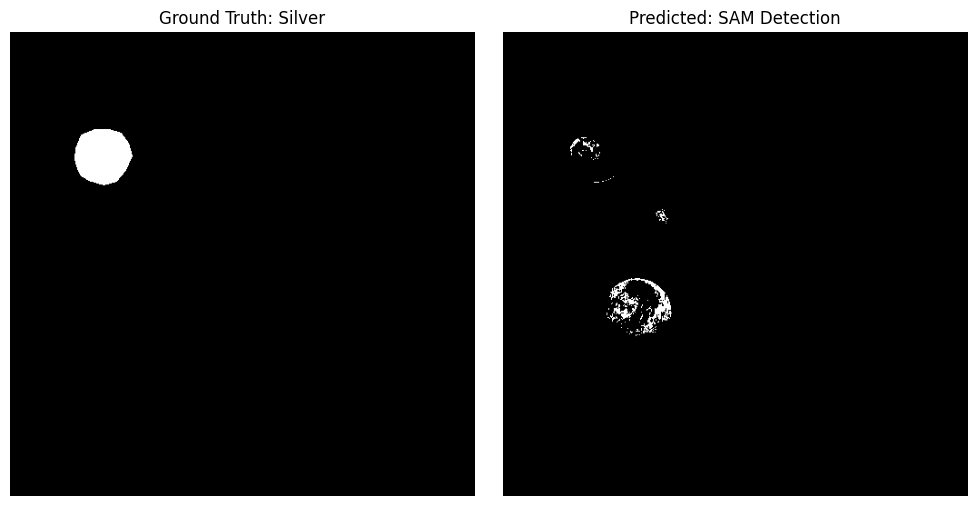

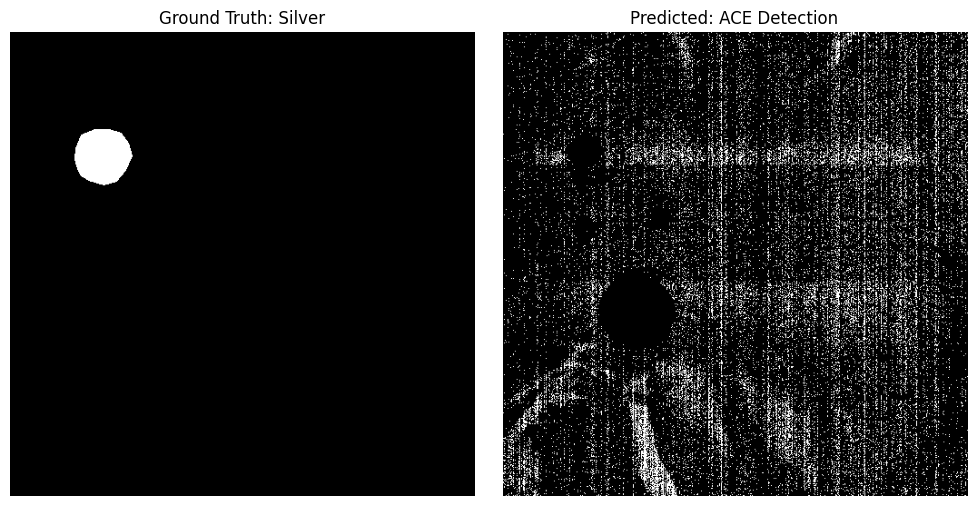

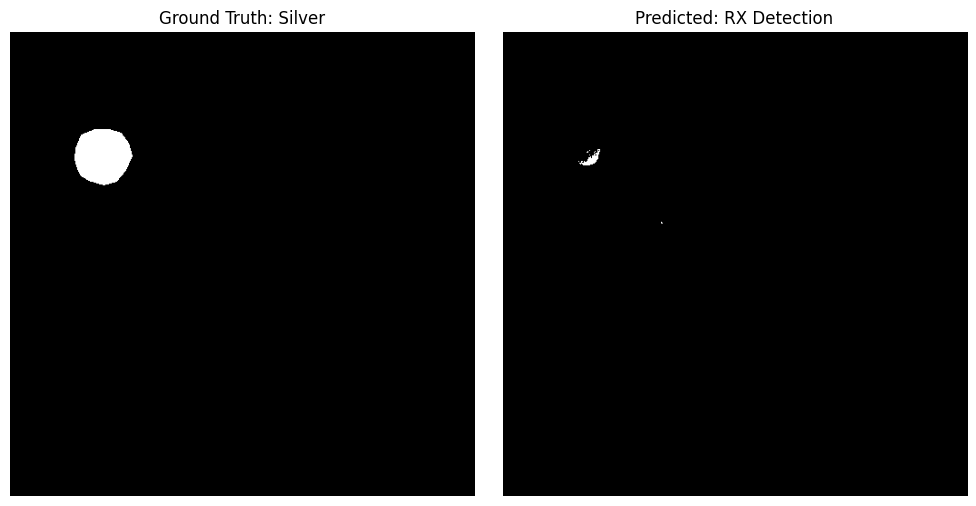


Processing Copper (Label 3)
Visualizing results for Copper (Label 3):


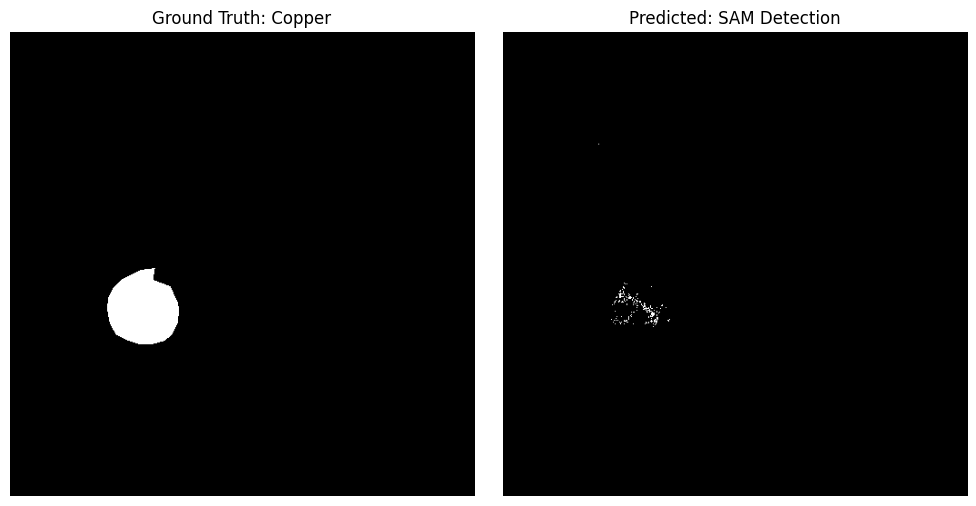

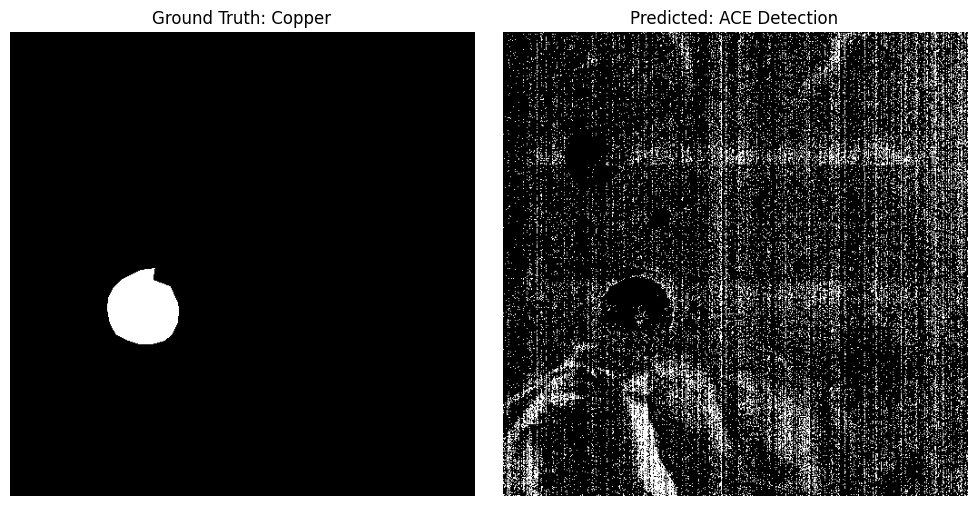

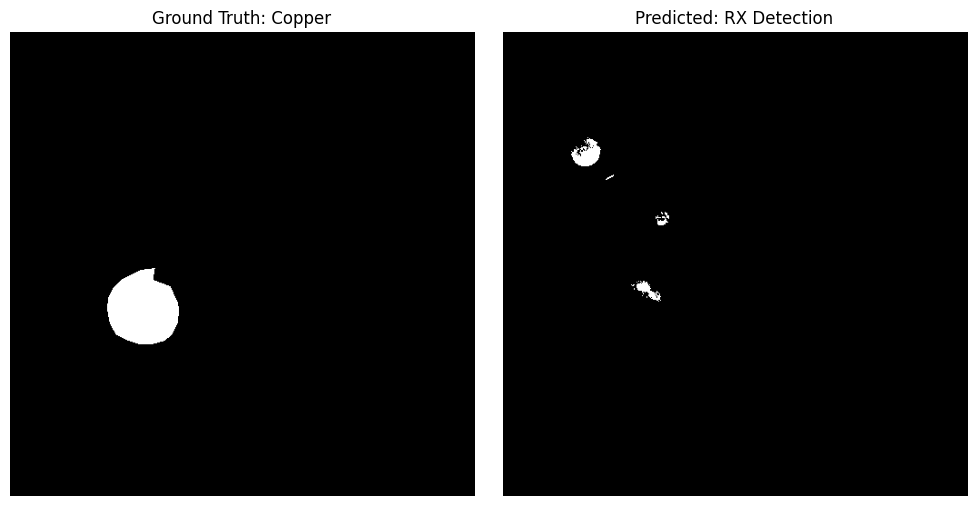


Results for Gold:
  SAM Metrics: Precision=1.0000, Recall=0.0526, F1-Score=0.1000, Accuracy=0.9991
  ACE Metrics: Precision=1.0000, Recall=0.0526, F1-Score=0.1000, Accuracy=0.9991
  RX Metrics: Precision=0.0379, Recall=0.0526, F1-Score=0.0441, Accuracy=0.9978

Results for Silver:
  SAM Metrics: Precision=0.1146, Recall=0.0502, F1-Score=0.0698, Accuracy=0.9843
  ACE Metrics: Precision=0.0050, Recall=0.0502, F1-Score=0.0091, Accuracy=0.8718
  RX Metrics: Precision=0.9809, Recall=0.0502, F1-Score=0.0955, Accuracy=0.9889

Results for Copper:
  SAM Metrics: Precision=0.9960, Recall=0.0501, F1-Score=0.0954, Accuracy=0.9820
  ACE Metrics: Precision=0.0061, Recall=0.0501, F1-Score=0.0108, Accuracy=0.8261
  RX Metrics: Precision=0.2596, Recall=0.0501, F1-Score=0.0840, Accuracy=0.9793


In [ ]:
import matplotlib.pyplot as plt

# Visualization of ground truth and predictions
def visualize_results(mask, binary_result, title, label_name):
    plt.figure(figsize=(10, 5))

    # Ground Truth
    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Ground Truth: {label_name}", fontsize=12)
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(binary_result, cmap='gray')
    plt.title(f"Predicted: {title}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Detect and evaluate for each target class
labels = {1: 'Gold', 2: 'Silver', 3: 'Copper'}
results = {}

for label, name in labels.items():
    print(f"\nProcessing {name} (Label {label})")
    target_spectrum = np.mean(calibrated_data[mask == label], axis=0)

    # Detection maps
    sam_result = spectral_angle_mapper(calibrated_data, target_spectrum)
    ace_result = adaptive_cosine_estimator(calibrated_data, target_spectrum)
    rx_result = rx_anomaly_detection(calibrated_data)

    # Convert to binary maps for the current target
    sam_binary = (sam_result < np.percentile(sam_result[mask == label], 5)).astype(int)  # Smallest 5% angles
    ace_binary = (ace_result > np.percentile(ace_result[mask == label], 95)).astype(int)  # Top 5% ACE scores
    rx_binary = (rx_result > np.percentile(rx_result[mask == label], 95)).astype(int)  # Top 5% anomalies

    # Evaluate performance
    sam_metrics = calculate_metrics(sam_binary, (mask == label).astype(int), average='binary')
    ace_metrics = calculate_metrics(ace_binary, (mask == label).astype(int), average='binary')
    rx_metrics = calculate_metrics(rx_binary, (mask == label).astype(int), average='binary')

    # Store results
    results[name] = {
        "SAM Metrics": sam_metrics,
        "ACE Metrics": ace_metrics,
        "RX Metrics": rx_metrics,
    }

    # Visualize results
    print(f"Visualizing results for {name} (Label {label}):")
    visualize_results((mask == label).astype(int), sam_binary, "SAM Detection", name)
    visualize_results((mask == label).astype(int), ace_binary, "ACE Detection", name)
    visualize_results((mask == label).astype(int), rx_binary, "RX Detection", name)

# Display Results
for target, metrics in results.items():
    print(f"\nResults for {target}:")
    for method, values in metrics.items():
        print(f"  {method}: Precision={values[0]:.4f}, Recall={values[1]:.4f}, F1-Score={values[2]:.4f}, Accuracy={values[3]:.4f}")


In [ ]:
!pip install spectral

In [ ]:
import numpy as np
! pip install spectral
import matplotlib.pyplot as plt
from spectral import envi

# Load the hyperspectral image and reference images
SCraw = envi.open('1873.hdr', '1873.raw')

# Open the white and dark reference images
white_reference = envi.open('WHITEREF_1873.hdr', image='WHITEREF_1873.raw')
dark_reference = envi.open('DARKREF_1873.hdr', image='DARKREF_1873.raw')

# Read the raw data and references as NumPy arrays
raw_data = SCraw.load()
white_data = white_reference.load()
dark_data = dark_reference.load()

# Subtract dark reference from raw image
calibrated_data1 = raw_data - dark_data

# Subtract dark reference from white reference
normalized_white = white_data - dark_data

# Divide calibrated image by normalized white reference
calibrated_data1 /= normalized_white


<ipython-input-21-4c0bdcf30e4b>:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  calibrated_data1 = raw_data - dark_data
<ipython-input-21-4c0bdcf30e4b>:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  normalized_white = white_data - dark_data


<ipython-input-22-a9bdb924bb4b>:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  calibrated_data1 = raw_data - dark_data
<ipython-input-22-a9bdb924bb4b>:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  normalized_white = white_data - dark_data


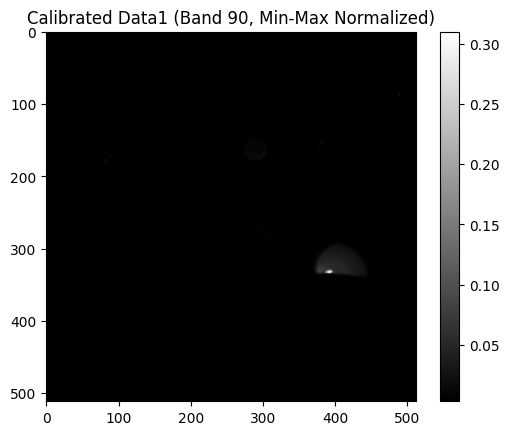

In [ ]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from spectral import envi

# Load the hyperspectral image and reference images
SCraw = envi.open('1873.hdr', '1873.raw')

# Open the white and dark reference images
white_reference = envi.open('WHITEREF_1873.hdr', image='WHITEREF_1873.raw')
dark_reference = envi.open('DARKREF_1873.hdr', image='DARKREF_1873.raw')

# Read the raw data and references as NumPy arrays
raw_data = SCraw.load()
white_data = white_reference.load()
dark_data = dark_reference.load()

# Subtract dark reference from raw image
calibrated_data1 = raw_data - dark_data

# Subtract dark reference from white reference
normalized_white = white_data - dark_data

# Divide calibrated image by normalized white reference
calibrated_data1 /= normalized_white

# Apply Savitzky-Golay filter along the spectral dimension
# Ensure the data has shape (height, width, bands)
bands = calibrated_data1.shape[-1]
for i in range(calibrated_data1.shape[0]):  # Iterate over height
    for j in range(calibrated_data1.shape[1]):  # Iterate over width
        calibrated_data1[i, j, :] = savgol_filter(
            calibrated_data1[i, j, :], window_length=11, polyorder=2
        )

# Apply Min-Max normalization to scale data between 0 and 1
calibrated_data_min = np.min(calibrated_data1)
calibrated_data_max = np.max(calibrated_data1)
calibrated_data1 = (calibrated_data1 - calibrated_data_min) / (calibrated_data_max - calibrated_data_min)

# Visualize an example band after normalization
plt.imshow(calibrated_data1[:, :, 90], cmap='gray')  # Example for the 50th band
plt.colorbar()
plt.title("Calibrated Data1 (Band 90, Min-Max Normalized)")
plt.show()


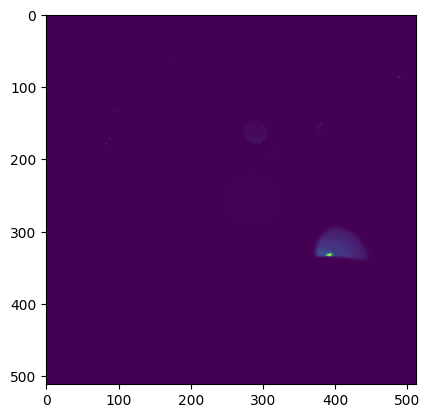

In [ ]:
plt.imshow(calibrated_data1[:,:,90])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Extract the 90th band
band_90 = calibrated_data1[:, :, 90]

# Normalize the data for visualization (optional, improves contrast)
band_90_normalized = (band_90 - band_90.min()) / (band_90.max() - band_90.min())

# Save the 90th band as a PNG image
plt.imsave('band_90.png', band_90_normalized, cmap=cm.gray)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select bands for red, green, and blue
# Adjust the indices based on your dataset's wavelength range
red_band = calibrated_data1[:, :, 60]  # Approximate red band
green_band = calibrated_data1[:, :, 30]  # Approximate green band
blue_band = calibrated_data1[:, :, 10]  # Approximate blue band

# Stack the selected bands to form an RGB image
rgb_image1 = np.dstack((red_band, green_band, blue_band))

# Normalize each channel to the 0-1 range for proper visualization
rgb_image1_normalized = (rgb_image1 - rgb_image1.min()) / (rgb_image1.max() - rgb_image1.min())

# Save the RGB image
plt.imsave('rgb_image1.png', rgb_image1_normalized)

print("RGB image saved as rgb_image1.png")


RGB image saved as rgb_image1.png


In [ ]:
import numpy as np
import json
import cv2

# Load the JSON file with annotations
with open('/content/labels_my-project-name_2024-11-18-12-32-05.json', 'r') as file:
    data = json.load(file)

# Initialize a blank mask with the same dimensions as the hyperspectral image
height, width = 512, 512  # Dimensions of the image
mask = np.zeros((height, width), dtype=np.uint8)

# Define the mapping of category names to label values
label_map = {'gold': 1, 'silver': 2, 'copper': 3}

# Loop through annotations to apply labels to the mask
for annotation in data['annotations']:
    category_id = annotation['category_id']
    segmentation = annotation['segmentation'][0]  # Use the first segmentation for this annotation

    # Reshape segmentation list into (x, y) coordinates
    points = np.array(segmentation).reshape(-1, 2)
    points = points.astype(np.int32)  # Convert to integer coordinates

    # Get the category name from the category_id
    category_name = next(cat['name'] for cat in data['categories'] if cat['id'] == category_id)

    # Fill the polygon on the mask
    cv2.fillPoly(mask, [points], label_map[category_name])

# Save the mask as a PNG
cv2.imwrite('label_mask1.png', mask)

print("Mask saved as label_mask1.png")


Mask saved as label_mask1.png


In [ ]:
import numpy as np
import cv2

# Load the saved label mask
mask = cv2.imread('label_mask1.png', cv2.IMREAD_GRAYSCALE)

# Define label-to-color mapping (background is white)
label_colors = {
    0: (255, 255, 255),  # Background - White
    1: (255, 0, 0),      # Gold - Red
    2: (0, 255, 0),      # Silver - Green
    3: (0, 0, 255)       # Copper - Blue
}

# Create a blank RGB image with the same dimensions as the mask
height, width = mask.shape
colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
label_mask1 = colored_mask
# Apply the colors to the mask based on label values
for label, color in label_colors.items():
    colored_mask[mask == label] = color

# Save the colored mask as a PNG image
cv2.imwrite('colored_label_mask_visualization.png', colored_mask)

print("Colored mask saved as colored_label_mask_visualization.png")


Colored mask saved as colored_label_mask_visualization.png


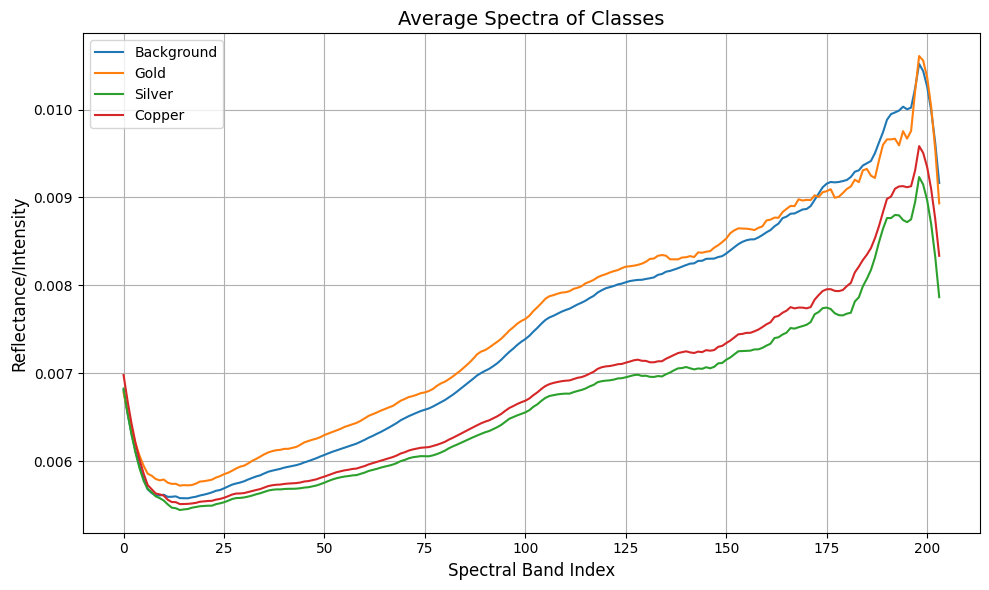

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the hyperspectral data (replace with actual data loading)
#calibrated_data2 = np.random.rand(512, 512, 204)  # Example: 512x512 image with 204 spectral bands

# Load the label mask
mask = cv2.imread('label_mask1.png', cv2.IMREAD_GRAYSCALE)

# Define the labels
labels = {
    0: 'Background',
    1: 'Gold',
    2: 'Silver',
    3: 'Copper'
}

# Initialize a dictionary to store average spectra for each class
average_spectra2 = {}

# Loop through each class and calculate the average spectra
for label in labels.keys():
    # Extract the pixels corresponding to the current label
    class_pixels = calibrated_data[mask == label]

    if class_pixels.size > 0:  # Ensure there are pixels for this class
        # Calculate the mean spectrum for the class
        avg_spectrum = np.mean(class_pixels, axis=0)
        average_spectra2[label] = avg_spectrum
    else:
        average_spectra2[label] = None  # Handle empty classes gracefully

# Plot the average spectra
plt.figure(figsize=(10, 6))
for label, spectrum in average_spectra2.items():
    if spectrum is not None:
        plt.plot(spectrum, label=labels[label])  # Plot spectrum with corresponding label

# Customize the plot
plt.title("Average Spectra of Classes", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Reflectance/Intensity", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


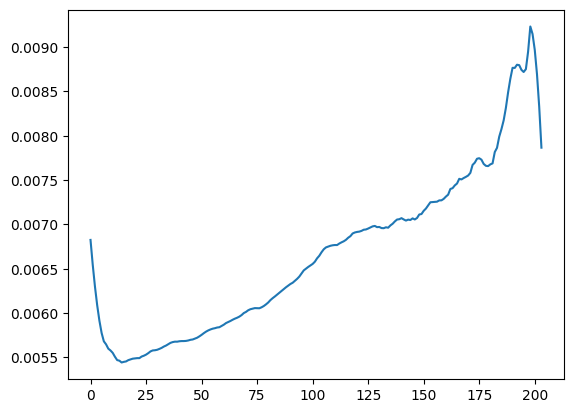

In [ ]:
plt.plot(average_spectra2.get(2))

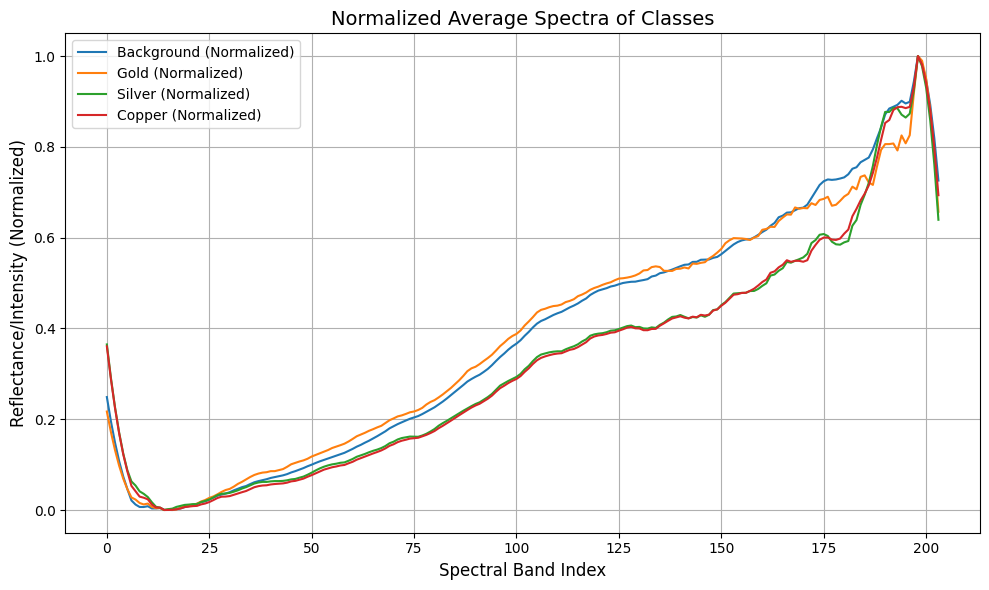

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the hyperspectral data (replace with actual data loading)
# calibrated_data is assumed to be available
mask = cv2.imread('label_mask1.png', cv2.IMREAD_GRAYSCALE)

# Define the labels
labels = {
    0: 'Background',
    1: 'Gold',
    2: 'Silver',
    3: 'Copper'
}

# Initialize a dictionary to store average spectra for each class
average_spectra2 = {}

# Loop through each class and calculate the average spectra
for label in labels.keys():
    # Extract the pixels corresponding to the current label
    class_pixels = calibrated_data[mask == label]

    if class_pixels.size > 0:  # Ensure there are pixels for this class
        # Calculate the mean spectrum for the class
        avg_spectrum = np.mean(class_pixels, axis=0)
        average_spectra2[label] = avg_spectrum
    else:
        average_spectra2[label] = None  # Handle empty classes gracefully

# Normalize each spectrum (0 to 1)
def normalize_spectrum(spectrum):
    """Normalize a spectrum to the range [0, 1]."""
    spectrum_min = np.min(spectrum)
    spectrum_max = np.max(spectrum)
    return (spectrum - spectrum_min) / (spectrum_max - spectrum_min)

# Apply normalization to average_spectra2
normalized_spectra2 = {
    label: normalize_spectrum(spectrum) if spectrum is not None else None
    for label, spectrum in average_spectra2.items()
}

# Plot the normalized spectra
plt.figure(figsize=(10, 6))
for label, spectrum in normalized_spectra2.items():
    if spectrum is not None:
        plt.plot(spectrum, label=f"{labels[label]} (Normalized)")

# Customize the plot
plt.title("Normalized Average Spectra of Classes", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Reflectance/Intensity (Normalized)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()



Processing Gold (Label 1)
Visualizing results for Gold (Label 1):


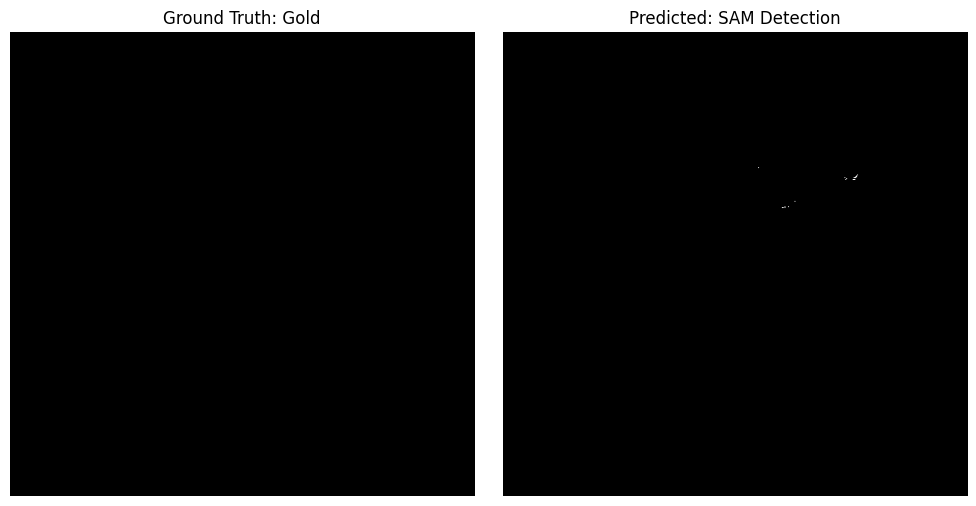

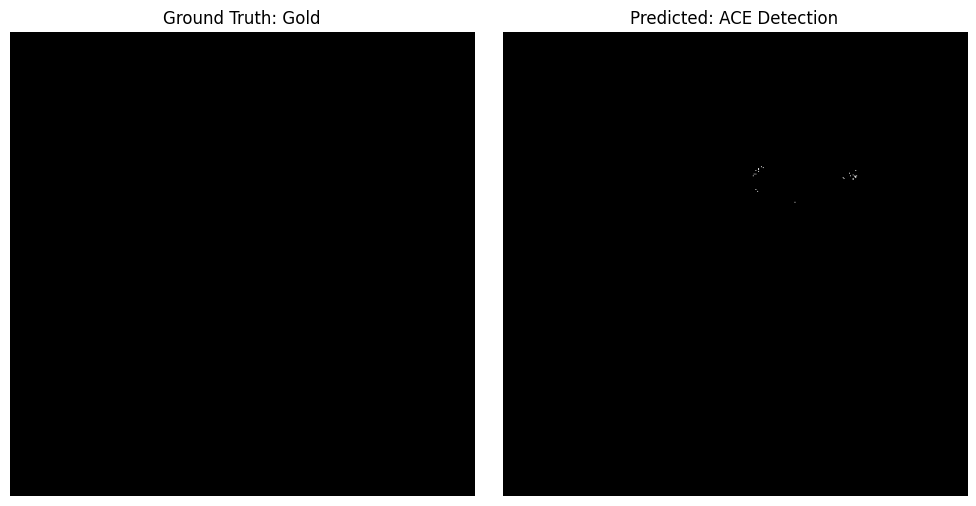

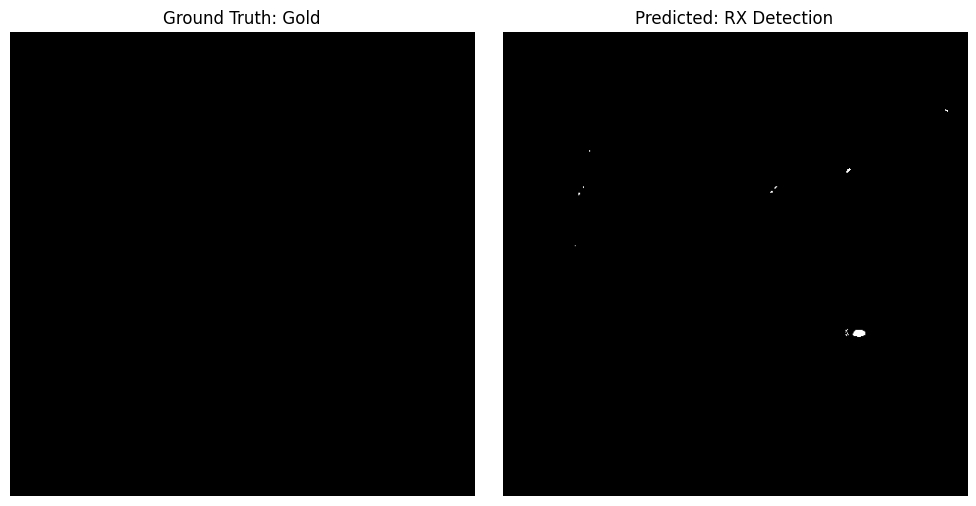


Processing Silver (Label 2)
Visualizing results for Silver (Label 2):


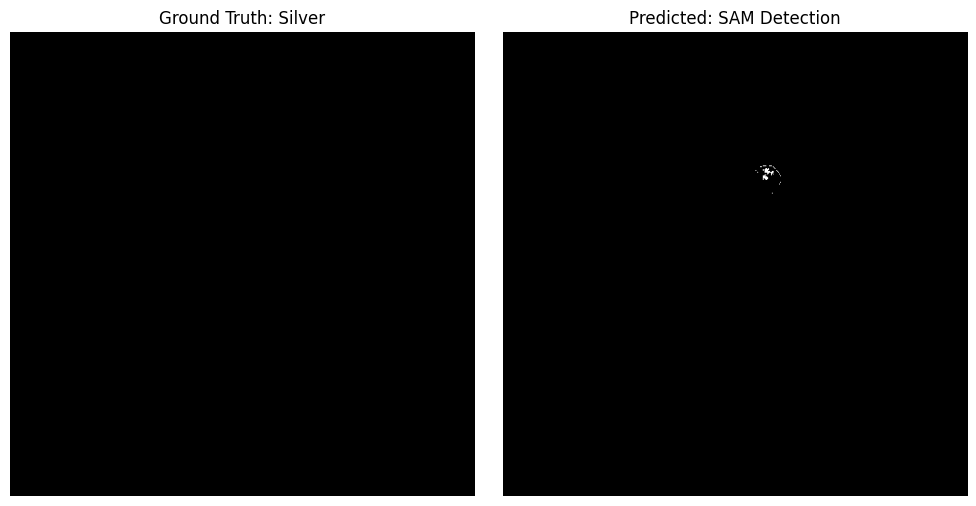

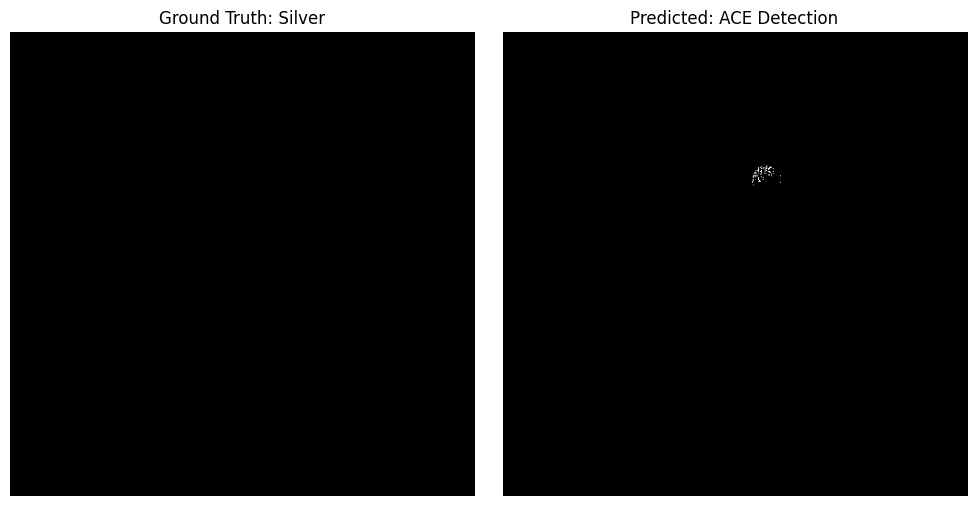

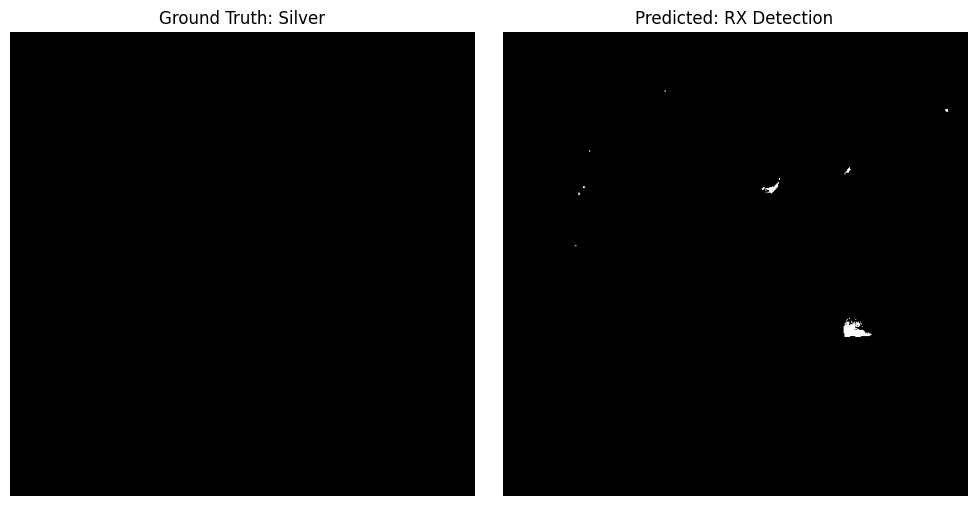


Processing Copper (Label 3)
Visualizing results for Copper (Label 3):


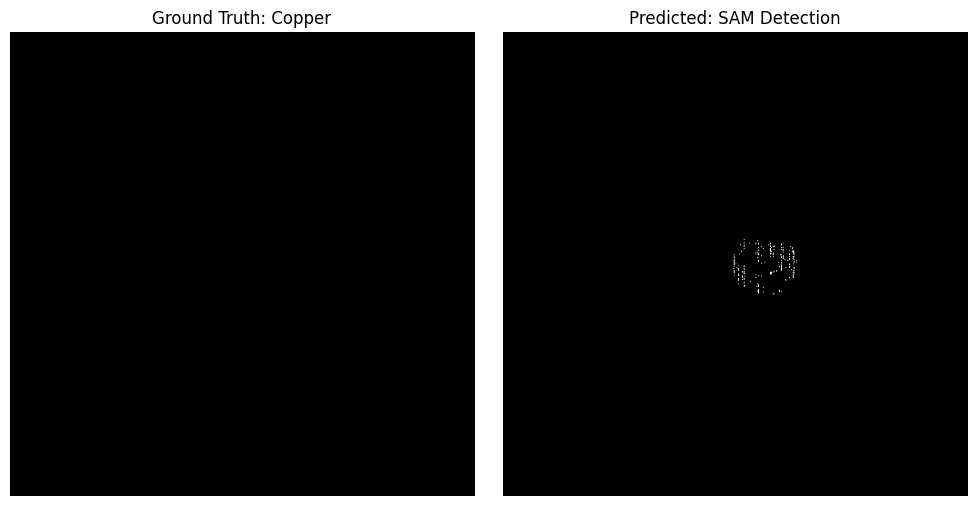

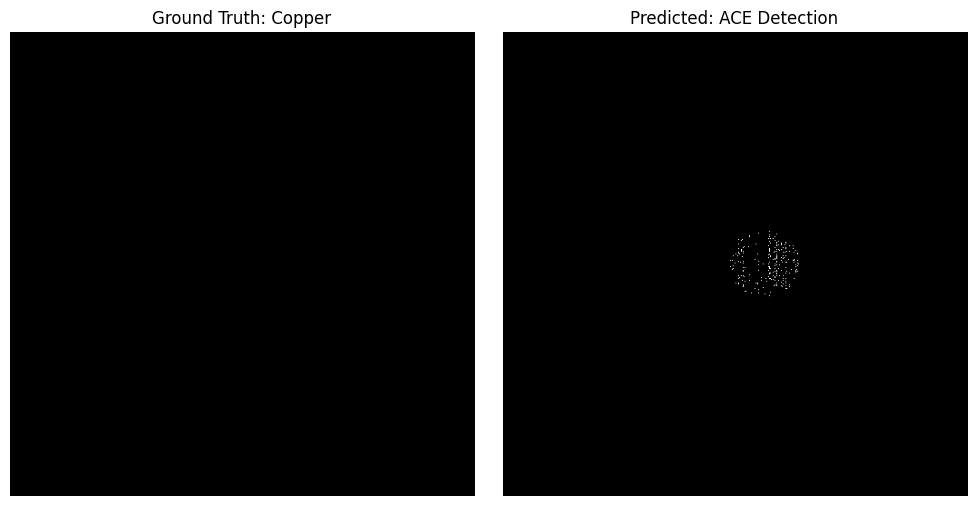

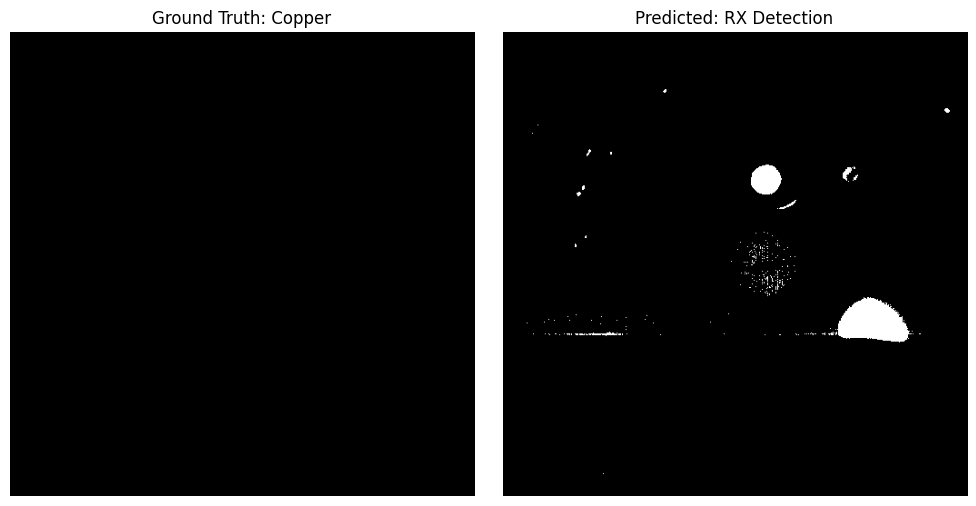


Results for Gold:
  SAM Metrics: Precision=0.6500, Recall=0.0528, F1-Score=0.0977, Accuracy=0.9991
  ACE Metrics: Precision=0.5200, Recall=0.0528, F1-Score=0.0959, Accuracy=0.9991
  RX Metrics: Precision=0.0949, Recall=0.0528, F1-Score=0.0679, Accuracy=0.9986

Results for Silver:
  SAM Metrics: Precision=0.9070, Recall=0.0506, F1-Score=0.0958, Accuracy=0.9944
  ACE Metrics: Precision=0.9750, Recall=0.0506, F1-Score=0.0962, Accuracy=0.9944
  RX Metrics: Precision=0.1765, Recall=0.0506, F1-Score=0.0786, Accuracy=0.9930

Results for Copper:
  SAM Metrics: Precision=0.9725, Recall=0.0502, F1-Score=0.0955, Accuracy=0.9847
  ACE Metrics: Precision=0.9217, Recall=0.0502, F1-Score=0.0952, Accuracy=0.9846
  RX Metrics: Precision=0.0498, Recall=0.0502, F1-Score=0.0500, Accuracy=0.9693


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from spectral import *
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming 'calibrated_data1' and 'label_mask1' are loaded
# 1. Spectral Angle Mapper (SAM)
def spectral_angle_mapper(image, target_spectrum):
    H, W, B = image.shape
    target_norm = np.linalg.norm(target_spectrum)
    sam_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel_spectrum = image[i, j, :]
            pixel_norm = np.linalg.norm(pixel_spectrum)
            angle = np.arccos(
                np.dot(pixel_spectrum, target_spectrum) / (pixel_norm * target_norm + 1e-8)
            )
            sam_map[i, j] = angle
    return sam_map

# 2. Adaptive Cosine Estimator (ACE)
def adaptive_cosine_estimator(image, target_spectrum):
    H, W, B = image.shape
    target_cov = np.cov(image.reshape(-1, B), rowvar=False)
    target_cov_inv = np.linalg.inv(target_cov + 1e-8 * np.eye(B))
    target_spectrum = target_spectrum.reshape(-1, 1)
    ace_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel_spectrum = image[i, j, :].reshape(-1, 1)
            numerator = np.dot(target_spectrum.T, np.dot(target_cov_inv, pixel_spectrum))
            denominator = (
                np.sqrt(np.dot(target_spectrum.T, np.dot(target_cov_inv, target_spectrum)))
                * np.sqrt(np.dot(pixel_spectrum.T, np.dot(target_cov_inv, pixel_spectrum)))
            )
            ace_map[i, j] = (numerator / (denominator + 1e-8)).item()
    return ace_map

# 3. RX Anomaly Detection
def rx_anomaly_detection(image):
    H, W, B = image.shape
    image_flat = image.reshape(-1, B)
    mean_vector = np.mean(image_flat, axis=0)
    cov_matrix = np.cov(image_flat, rowvar=False)
    cov_inv = np.linalg.inv(cov_matrix + 1e-8 * np.eye(B))
    rx_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel = image[i, j, :]
            diff = pixel - mean_vector
            rx_map[i, j] = np.dot(diff.T, np.dot(cov_inv, diff))
    return rx_map

# Performance Metrics
def calculate_metrics(binary_result, ground_truth, average='macro'):
    binary_result_flat = binary_result.flatten()
    ground_truth_flat = ground_truth.flatten()

    precision = precision_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    recall = recall_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    f1 = f1_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    accuracy = accuracy_score(ground_truth_flat, binary_result_flat)

    return precision, recall, f1, accuracy

# Visualization of ground truth and predictions
def visualize_results(mask, binary_result, title, label_name):
    plt.figure(figsize=(10, 5))

    # Ground Truth
    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Ground Truth: {label_name}", fontsize=12)
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(binary_result, cmap='gray')
    plt.title(f"Predicted: {title}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Detect and evaluate for each target class in the second HSI image
labels = {1: 'Gold', 2: 'Silver', 3: 'Copper'}
results = {}

for label, name in labels.items():
    print(f"\nProcessing {name} (Label {label})")

    mask_grayscale = cv2.imread('label_mask1.png', cv2.IMREAD_GRAYSCALE)
    target_spectrum = np.mean(calibrated_data1[mask_grayscale == label], axis=0)

    # Detection maps
    sam_result = spectral_angle_mapper(calibrated_data1, target_spectrum)
    ace_result = adaptive_cosine_estimator(calibrated_data1, target_spectrum)
    rx_result = rx_anomaly_detection(calibrated_data1)

    # Convert to binary maps for the current target
    sam_binary = (sam_result < np.percentile(sam_result[mask_grayscale == label], 5)).astype(int)  # Smallest 5% angles
    ace_binary = (ace_result > np.percentile(ace_result[mask_grayscale == label], 95)).astype(int)  # Top 5% ACE scores
    rx_binary = (rx_result > np.percentile(rx_result[mask_grayscale == label], 95)).astype(int)  # Top 5% anomalies

    # Evaluate performance
    sam_metrics = calculate_metrics(sam_binary, (mask_grayscale == label).astype(int), average='binary')
    ace_metrics = calculate_metrics(ace_binary, (mask_grayscale == label).astype(int), average='binary')
    rx_metrics = calculate_metrics(rx_binary, (mask_grayscale == label).astype(int), average='binary')

    # Store results
    results[name] = {
        "SAM Metrics": sam_metrics,
        "ACE Metrics": ace_metrics,
        "RX Metrics": rx_metrics,
    }

    # Visualize results
    print(f"Visualizing results for {name} (Label {label}):")
    visualize_results((label_mask1 == label).astype(int), sam_binary, "SAM Detection", name)
    visualize_results((label_mask1 == label).astype(int), ace_binary, "ACE Detection", name)
    visualize_results((label_mask1 == label).astype(int), rx_binary, "RX Detection", name)

# Display Results
for target, metrics in results.items():
    print(f"\nResults for {target}:")
    for method, values in metrics.items():
        print(f"  {method}: Precision={values[0]:.4f}, Recall={values[1]:.4f}, F1-Score={values[2]:.4f}, Accuracy={values[3]:.4f}")


In [ ]:
import numpy as np
from spectral import *
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assume `calibrated_data` (H x W x Bands) and `mask` (H x W) are loaded
# `mask` contains ground truth labels:
# 0 = Background, 1 = Gold, 2 = Silver, 3 = Copper

# 1. Spectral Angle Mapper (SAM)
def spectral_angle_mapper(image, target_spectrum):
    H, W, B = image.shape
    target_norm = np.linalg.norm(target_spectrum)
    sam_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel_spectrum = image[i, j, :]
            pixel_norm = np.linalg.norm(pixel_spectrum)
            angle = np.arccos(
                np.dot(pixel_spectrum, target_spectrum) / (pixel_norm * target_norm + 1e-8)
            )
            sam_map[i, j] = angle
    return sam_map

# 2. Adaptive Cosine Estimator (ACE)
def adaptive_cosine_estimator(image, target_spectrum):
    H, W, B = image.shape
    target_cov = np.cov(image.reshape(-1, B), rowvar=False)
    target_cov_inv = np.linalg.inv(target_cov + 1e-8 * np.eye(B))
    target_spectrum = target_spectrum.reshape(-1, 1)
    ace_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel_spectrum = image[i, j, :].reshape(-1, 1)
            numerator = np.dot(target_spectrum.T, np.dot(target_cov_inv, pixel_spectrum))
            denominator = (
                np.sqrt(np.dot(target_spectrum.T, np.dot(target_cov_inv, target_spectrum)))
                * np.sqrt(np.dot(pixel_spectrum.T, np.dot(target_cov_inv, pixel_spectrum)))
            )
            ace_map[i, j] = (numerator / (denominator + 1e-8)).item()
    return ace_map

# 3. RX Anomaly Detection
def rx_anomaly_detection(image):
    H, W, B = image.shape
    image_flat = image.reshape(-1, B)
    mean_vector = np.mean(image_flat, axis=0)
    cov_matrix = np.cov(image_flat, rowvar=False)
    cov_inv = np.linalg.inv(cov_matrix + 1e-8 * np.eye(B))
    rx_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel = image[i, j, :]
            diff = pixel - mean_vector
            rx_map[i, j] = np.dot(diff.T, np.dot(cov_inv, diff))
    return rx_map

# Performance Metrics
def calculate_metrics(binary_result, ground_truth, average='macro'):
    binary_result_flat = binary_result.flatten()
    ground_truth_flat = ground_truth.flatten()

    precision = precision_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    recall = recall_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    f1 = f1_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    accuracy = accuracy_score(ground_truth_flat, binary_result_flat)

    return precision, recall, f1, accuracy

# Detect and evaluate for each target class
labels = {1: 'Gold', 2: 'Silver', 3: 'Copper'}
results = {}

for label, name in labels.items():
    print(f"\nProcessing {name} (Label {label})")
    target_spectrum = np.mean(calibrated_data1[mask == label], axis=0)

    # Detection maps
    sam_result = spectral_angle_mapper(calibrated_data1, target_spectrum)
    ace_result = adaptive_cosine_estimator(calibrated_data1, target_spectrum)
    rx_result = rx_anomaly_detection(calibrated_data1)

    # Convert to binary maps for the current target
    sam_binary = (sam_result < np.percentile(sam_result[mask == label], 5)).astype(int)  # Smallest 5% angles
    ace_binary = (ace_result > np.percentile(ace_result[mask == label], 95)).astype(int)  # Top 5% ACE scores
    rx_binary = (rx_result > np.percentile(rx_result[mask == label], 95)).astype(int)  # Top 5% anomalies

    # Evaluate performance
    sam_metrics = calculate_metrics(sam_binary, (mask == label).astype(int), average='binary')
    ace_metrics = calculate_metrics(ace_binary, (mask == label).astype(int), average='binary')
    rx_metrics = calculate_metrics(rx_binary, (mask == label).astype(int), average='binary')

    # Store results
    results[name] = {
        "SAM Metrics": sam_metrics,
        "ACE Metrics": ace_metrics,
        "RX Metrics": rx_metrics,
    }

# Display Results
for target, metrics in results.items():
    print(f"\nResults for {target}:")
    for method, values in metrics.items():
        print(f"  {method}: Precision={values[0]:.4f}, Recall={values[1]:.4f}, F1-Score={values[2]:.4f}, Accuracy={values[3]:.4f}")



Processing Gold (Label 1)

Processing Silver (Label 2)

Processing Copper (Label 3)

Results for Gold:
  SAM Metrics: Precision=0.6500, Recall=0.0528, F1-Score=0.0977, Accuracy=0.9991
  ACE Metrics: Precision=0.5200, Recall=0.0528, F1-Score=0.0959, Accuracy=0.9991
  RX Metrics: Precision=0.0949, Recall=0.0528, F1-Score=0.0679, Accuracy=0.9986

Results for Silver:
  SAM Metrics: Precision=0.9070, Recall=0.0506, F1-Score=0.0958, Accuracy=0.9944
  ACE Metrics: Precision=0.9750, Recall=0.0506, F1-Score=0.0962, Accuracy=0.9944
  RX Metrics: Precision=0.1765, Recall=0.0506, F1-Score=0.0786, Accuracy=0.9930

Results for Copper:
  SAM Metrics: Precision=0.9725, Recall=0.0502, F1-Score=0.0955, Accuracy=0.9847
  ACE Metrics: Precision=0.9217, Recall=0.0502, F1-Score=0.0952, Accuracy=0.9846
  RX Metrics: Precision=0.0498, Recall=0.0502, F1-Score=0.0500, Accuracy=0.9693


In [ ]:
import numpy as np
! pip install spectral
import matplotlib.pyplot as plt
from spectral import envi

# Load the hyperspectral image and reference images
SCraw = envi.open('1874.hdr', '1874.raw')

# Open the white and dark reference images
white_reference = envi.open('WHITEREF_1874.hdr', image='WHITEREF_1874.raw')
dark_reference = envi.open('DARKREF_1874.hdr', image='DARKREF_1874.raw')

# Read the raw data and references as NumPy arrays
raw_data = SCraw.load()
white_data = white_reference.load()
dark_data = dark_reference.load()

# Subtract dark reference from raw image
calibrated_data2 = raw_data - dark_data

# Subtract dark reference from white reference
normalized_white = white_data - dark_data

# Divide calibrated image by normalized white reference
calibrated_data2  /= normalized_white


<ipython-input-33-a1570b635c6f>:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  calibrated_data2 = raw_data - dark_data
<ipython-input-33-a1570b635c6f>:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  normalized_white = white_data - dark_data


<ipython-input-34-33a221745baa>:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  calibrated_data2 = raw_data - dark_data
<ipython-input-34-33a221745baa>:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  normalized_white = white_data - dark_data


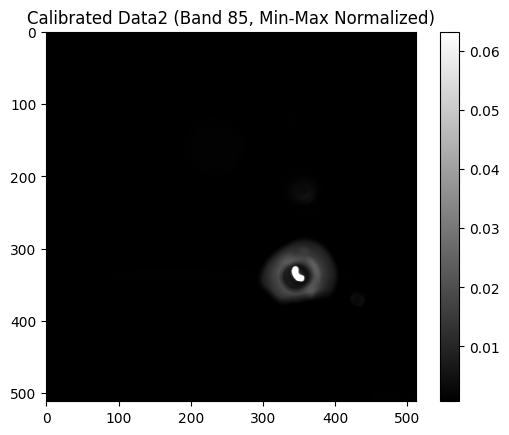

In [ ]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from spectral import envi

# Load the hyperspectral image and reference images
SCraw = envi.open('1874.hdr', '1874.raw')

# Open the white and dark reference images
white_reference = envi.open('WHITEREF_1874.hdr', image='WHITEREF_1874.raw')
dark_reference = envi.open('DARKREF_1874.hdr', image='DARKREF_1874.raw')

# Read the raw data and references as NumPy arrays
raw_data = SCraw.load()
white_data = white_reference.load()
dark_data = dark_reference.load()

# Subtract dark reference from raw image
calibrated_data2 = raw_data - dark_data

# Subtract dark reference from white reference
normalized_white = white_data - dark_data

# Divide calibrated image by normalized white reference
calibrated_data2 /= normalized_white

# Apply Savitzky-Golay filter along the spectral dimension
# Ensure the data has shape (height, width, bands)
bands = calibrated_data2.shape[-1]
for i in range(calibrated_data2.shape[0]):  # Iterate over height
    for j in range(calibrated_data2.shape[1]):  # Iterate over width
        calibrated_data2[i, j, :] = savgol_filter(
            calibrated_data2[i, j, :], window_length=11, polyorder=2
        )

# Apply Min-Max normalization to scale data between 0 and 1
calibrated_data_min = np.min(calibrated_data2)
calibrated_data_max = np.max(calibrated_data2)
calibrated_data2 = (calibrated_data2 - calibrated_data_min) / (calibrated_data_max - calibrated_data_min)

# Visualize an example band after normalization
plt.imshow(calibrated_data2[:, :, 85], cmap='gray')  # Example for the 50th band
plt.colorbar()
plt.title("Calibrated Data2 (Band 85, Min-Max Normalized)")
plt.show()


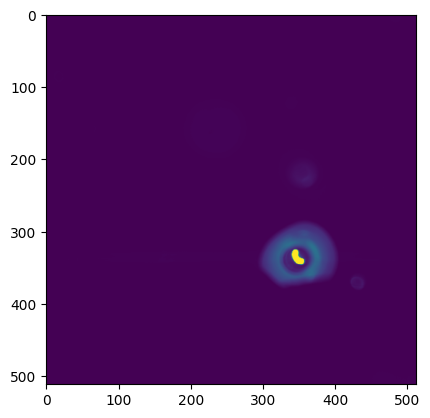

In [ ]:
plt.imshow(calibrated_data2[:,:,85])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Assuming calibrated_data2 is your hyperspectral dataset
# Extract the 85th band
band_85 = calibrated_data2[:, :, 85]

# Normalize data for better visualization (if necessary)
band_85_normalized = (band_85 - band_85.min()) / (band_85.max() - band_85.min())

# Save as PNG
plt.imsave('band_85.png', band_85_normalized, cmap=cm.gray)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming calibrated_data2 is your hyperspectral dataset
# Select bands for Red, Green, and Blue channels
red_band = calibrated_data2[:, :, 60]   # Replace with appropriate band index for red
green_band = calibrated_data2[:, :, 30] # Replace with appropriate band index for green
blue_band = calibrated_data2[:, :, 10]  # Replace with appropriate band index for blue

# Stack the selected bands to form an RGB image
rgb_image2 = np.dstack((red_band, green_band, blue_band))

# Normalize each channel to the [0, 1] range
rgb_image2_normalized = (rgb_image2 - rgb_image2.min()) / (rgb_image2.max() - rgb_image2.min())

# Save the RGB image
plt.imsave('rgb_image2.png', rgb_image2_normalized)



In [ ]:
import numpy as np
import json
import cv2

# Load the JSON file with annotations
with open('/content/labels_my-project-name_2024-11-18-01-01-29.json', 'r') as file:
    data = json.load(file)

# Initialize a blank mask with the same dimensions as the hyperspectral image
height, width = 512, 512  # Dimensions of the image
mask = np.zeros((height, width), dtype=np.uint8)

# Define the mapping of category names to label values
label_map = {'gold': 1, 'silver': 2, 'copper': 3}

# Loop through annotations to apply labels to the mask
for annotation in data['annotations']:
    category_id = annotation['category_id']
    segmentation = annotation['segmentation'][0]  # Use the first segmentation for this annotation

    # Reshape segmentation list into (x, y) coordinates
    points = np.array(segmentation).reshape(-1, 2)
    points = points.astype(np.int32)  # Convert to integer coordinates

    # Get the category name from the category_id
    category_name = next(cat['name'] for cat in data['categories'] if cat['id'] == category_id)

    # Fill the polygon on the mask
    cv2.fillPoly(mask, [points], label_map[category_name])

# Save the mask as a PNG
cv2.imwrite('label_mask2.png', mask)

print("Mask saved as label_mask2.png")


Mask saved as label_mask2.png


In [ ]:
import numpy as np
import cv2

# Load the saved label mask
mask = cv2.imread('label_mask2.png', cv2.IMREAD_GRAYSCALE)

# Define label-to-color mapping
label_colors = {
    0: (255, 255, 255),  # Background - White
    1: (255, 0, 0),      # Gold - Red
    2: (0, 255, 0),      # Silver - Green
    3: (0, 0, 255)       # Copper - Blue
}

# Create a blank RGB image with the same dimensions as the mask
height, width = mask.shape
colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

# Apply the colors to the mask based on label values
for label, color in label_colors.items():
    colored_mask[mask == label] = color

# Save the colored mask as a PNG image
cv2.imwrite('colored_label_mask2.png', colored_mask)

print("Colored mask saved as colored_label_mask2.png")


Colored mask saved as colored_label_mask2.png


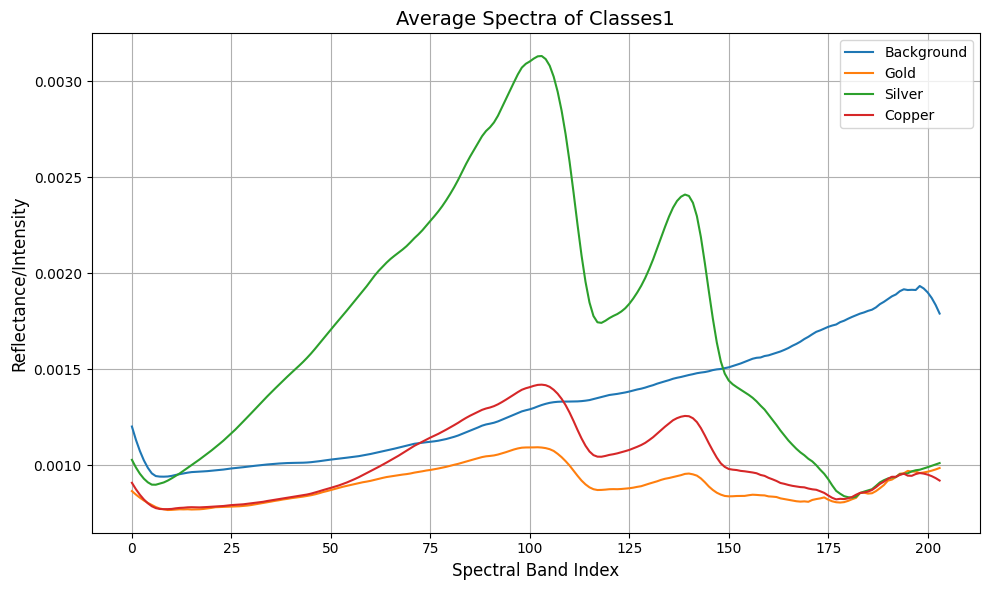

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the hyperspectral data (replace with actual data loading)
#calibrated_data2 = np.random.rand(512, 512, 204)  # Example: 512x512 image with 204 spectral bands

# Load the label mask
mask = cv2.imread('label_mask2.png', cv2.IMREAD_GRAYSCALE)

# Define the labels
labels = {
    0: 'Background',
    1: 'Gold',
    2: 'Silver',
    3: 'Copper'
}

# Initialize a dictionary to store average spectra for each class
average_spectra3 = {}

# Loop through each class and calculate the average spectra
for label in labels.keys():
    # Extract the pixels corresponding to the current label
    class_pixels = calibrated_data2[mask == label]

    if class_pixels.size > 0:  # Ensure there are pixels for this class
        # Calculate the mean spectrum for the class
        avg_spectrum = np.mean(class_pixels, axis=0)
        average_spectra3[label] = avg_spectrum
    else:
        average_spectra3[label] = None  # Handle empty classes gracefully

# Plot the average spectra
plt.figure(figsize=(10, 6))
for label, spectrum in average_spectra3.items():
    if spectrum is not None:
        plt.plot(spectrum, label=labels[label])  # Plot spectrum with corresponding label

# Customize the plot
plt.title("Average Spectra of Classes1", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Reflectance/Intensity", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


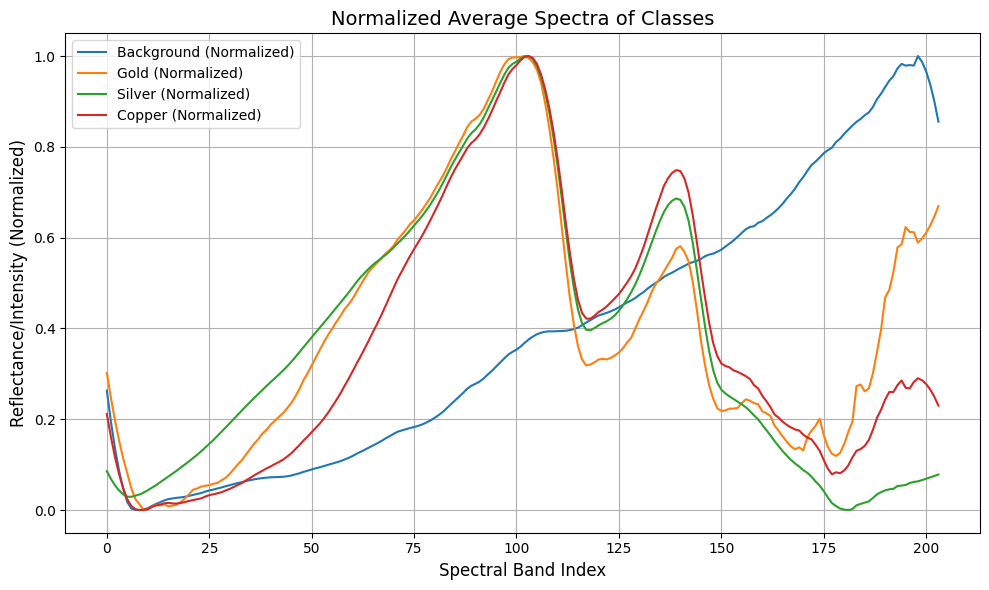

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the hyperspectral data (replace with actual data loading)
# calibrated_data2 is assumed to be available
mask = cv2.imread('label_mask2.png', cv2.IMREAD_GRAYSCALE)

# Define the labels
labels = {
    0: 'Background',
    1: 'Gold',
    2: 'Silver',
    3: 'Copper'
}

# Initialize a dictionary to store average spectra for each class
average_spectra3 = {}

# Loop through each class and calculate the average spectra
for label in labels.keys():
    # Extract the pixels corresponding to the current label
    class_pixels = calibrated_data2[mask == label]

    if class_pixels.size > 0:  # Ensure there are pixels for this class
        # Calculate the mean spectrum for the class
        avg_spectrum = np.mean(class_pixels, axis=0)
        average_spectra3[label] = avg_spectrum
    else:
        average_spectra3[label] = None  # Handle empty classes gracefully

# Normalize each spectrum (0 to 1)
def normalize_spectrum(spectrum):
    """Normalize a spectrum to the range [0, 1]."""
    spectrum_min = np.min(spectrum)
    spectrum_max = np.max(spectrum)
    return (spectrum - spectrum_min) / (spectrum_max - spectrum_min)

# Apply normalization to average_spectra3
normalized_spectra3 = {
    label: normalize_spectrum(spectrum) if spectrum is not None else None
    for label, spectrum in average_spectra3.items()
}

# Plot the normalized spectra
plt.figure(figsize=(10, 6))
for label, spectrum in normalized_spectra3.items():
    if spectrum is not None:
        plt.plot(spectrum, label=f"{labels[label]} (Normalized)")

# Customize the plot
plt.title("Normalized Average Spectra of Classes", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Reflectance/Intensity (Normalized)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()



Processing Gold (Label 1)
Visualizing results for Gold (Label 1):


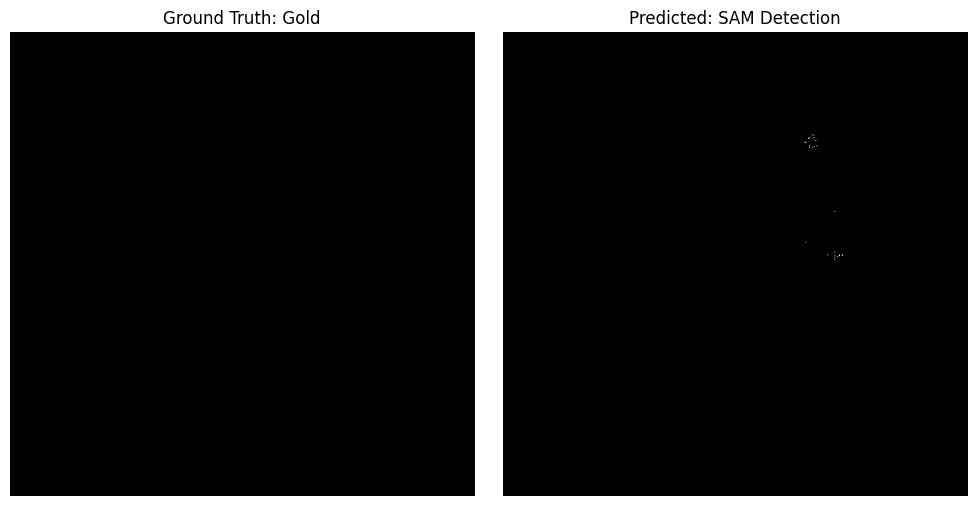

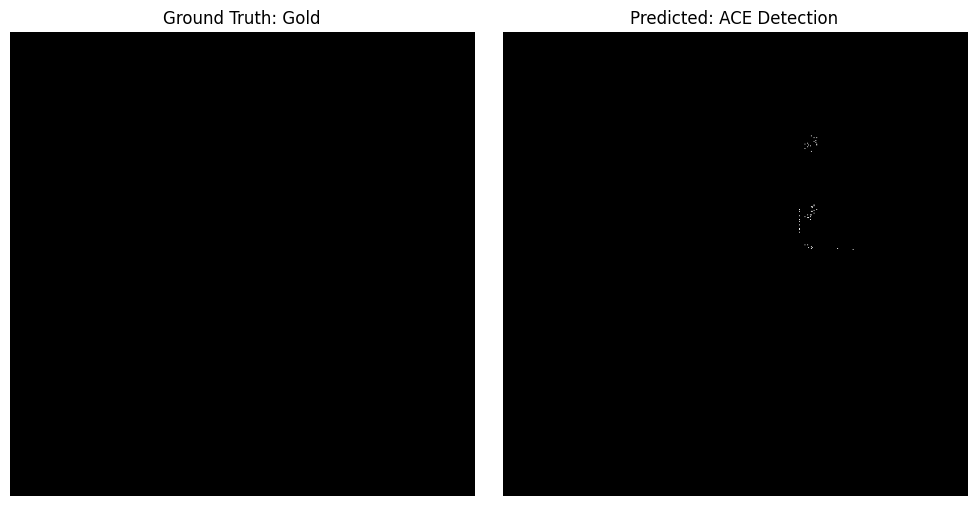

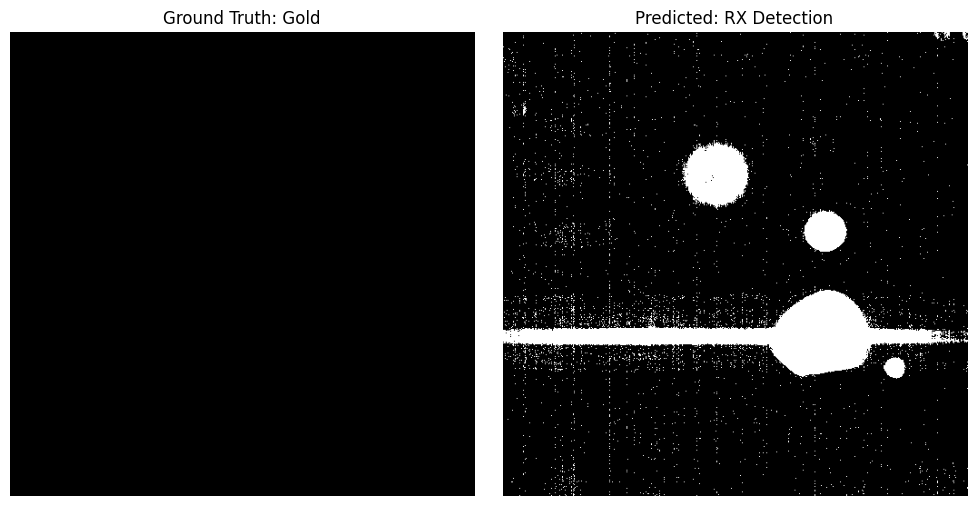


Processing Silver (Label 2)
Visualizing results for Silver (Label 2):


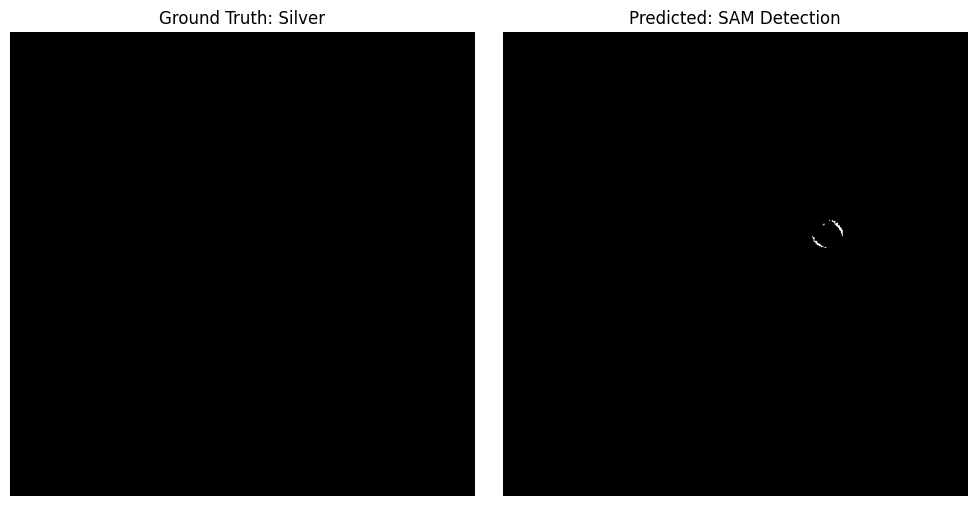

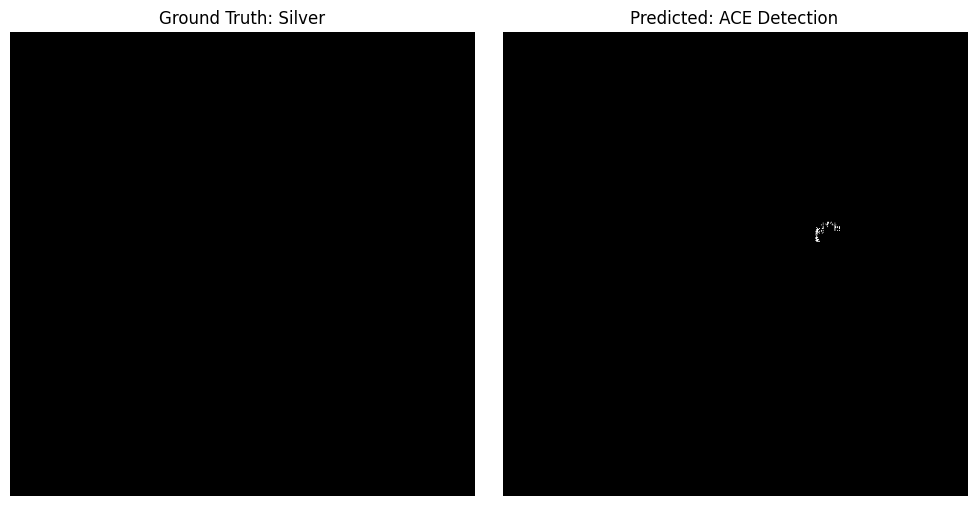

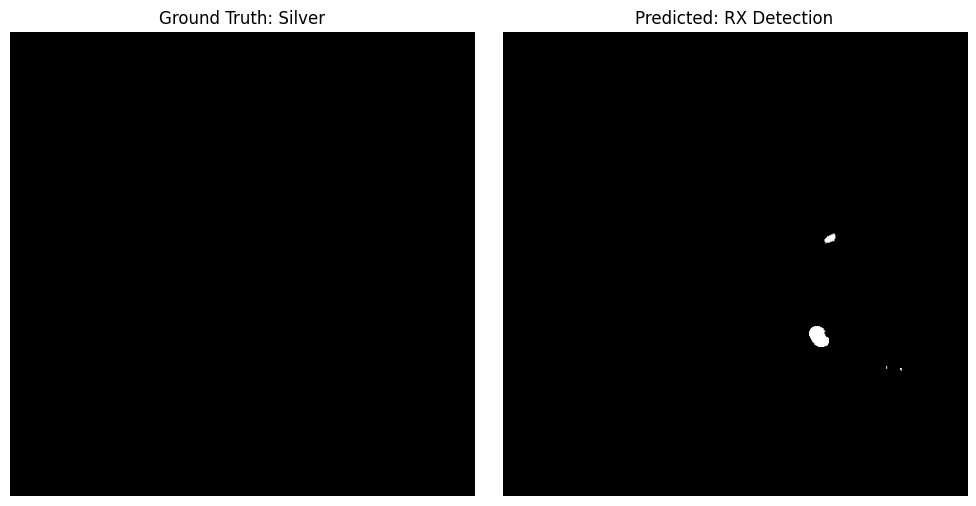


Processing Copper (Label 3)
Visualizing results for Copper (Label 3):


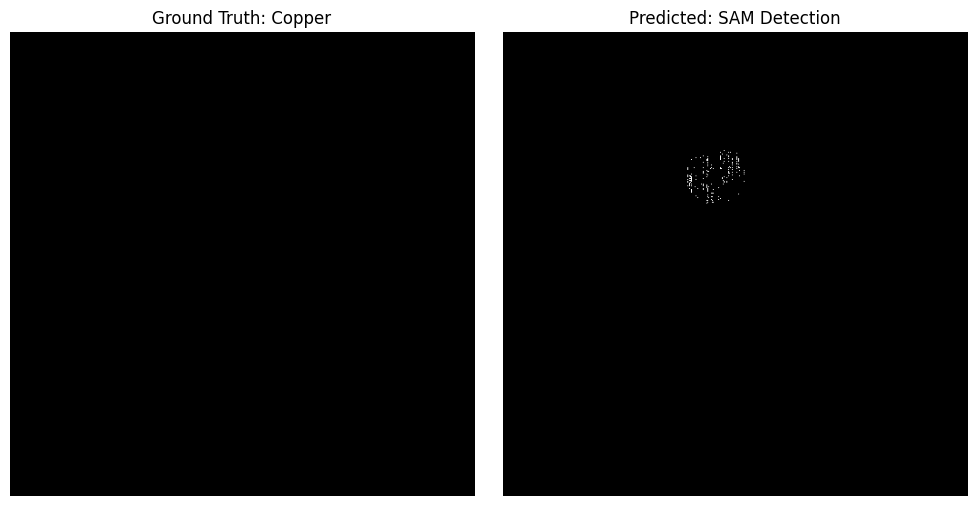

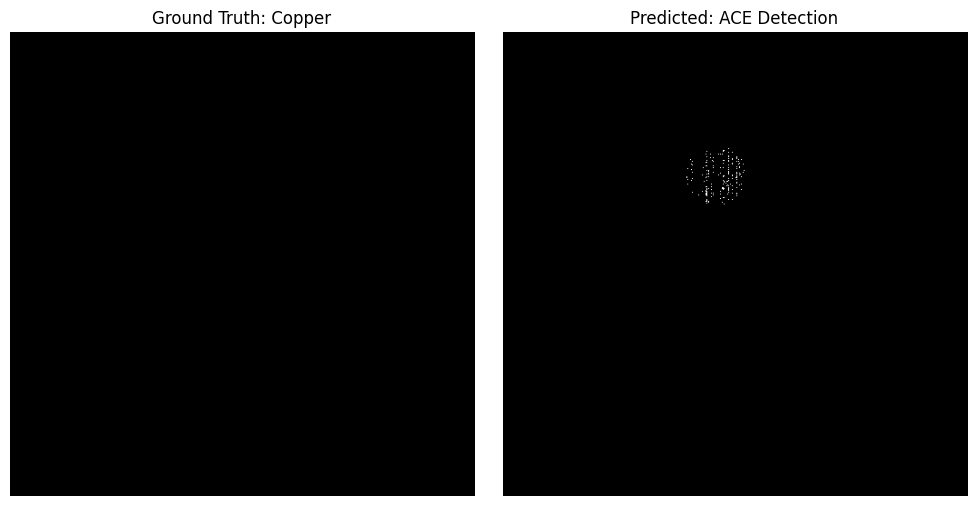

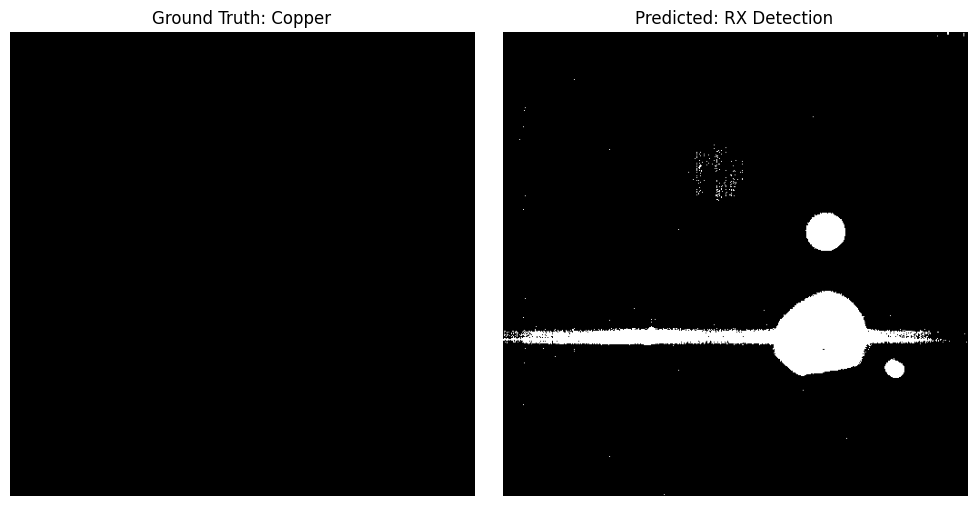


Results for Gold:
  SAM Metrics: Precision=0.4800, Recall=0.0522, F1-Score=0.0941, Accuracy=0.9991
  ACE Metrics: Precision=0.2400, Recall=0.0522, F1-Score=0.0857, Accuracy=0.9990
  RX Metrics: Precision=0.0005, Recall=0.0522, F1-Score=0.0010, Accuracy=0.9062

Results for Silver:
  SAM Metrics: Precision=1.0000, Recall=0.0500, F1-Score=0.0952, Accuracy=0.9941
  ACE Metrics: Precision=1.0000, Recall=0.0500, F1-Score=0.0952, Accuracy=0.9941
  RX Metrics: Precision=0.1772, Recall=0.0500, F1-Score=0.0780, Accuracy=0.9927

Results for Copper:
  SAM Metrics: Precision=1.0000, Recall=0.0501, F1-Score=0.0955, Accuracy=0.9866
  ACE Metrics: Precision=0.9947, Recall=0.0501, F1-Score=0.0954, Accuracy=0.9865
  RX Metrics: Precision=0.0128, Recall=0.0501, F1-Score=0.0204, Accuracy=0.9320


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from spectral import *
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming 'calibrated_data1' and 'label_mask1' are loaded
# 1. Spectral Angle Mapper (SAM)
def spectral_angle_mapper(image, target_spectrum):
    H, W, B = image.shape
    target_norm = np.linalg.norm(target_spectrum)
    sam_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel_spectrum = image[i, j, :]
            pixel_norm = np.linalg.norm(pixel_spectrum)
            angle = np.arccos(
                np.dot(pixel_spectrum, target_spectrum) / (pixel_norm * target_norm + 1e-8)
            )
            sam_map[i, j] = angle
    return sam_map

# 2. Adaptive Cosine Estimator (ACE)
def adaptive_cosine_estimator(image, target_spectrum):
    H, W, B = image.shape
    target_cov = np.cov(image.reshape(-1, B), rowvar=False)
    target_cov_inv = np.linalg.inv(target_cov + 1e-8 * np.eye(B))
    target_spectrum = target_spectrum.reshape(-1, 1)
    ace_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel_spectrum = image[i, j, :].reshape(-1, 1)
            numerator = np.dot(target_spectrum.T, np.dot(target_cov_inv, pixel_spectrum))
            denominator = (
                np.sqrt(np.dot(target_spectrum.T, np.dot(target_cov_inv, target_spectrum)))
                * np.sqrt(np.dot(pixel_spectrum.T, np.dot(target_cov_inv, pixel_spectrum)))
            )
            ace_map[i, j] = (numerator / (denominator + 1e-8)).item()
    return ace_map

# 3. RX Anomaly Detection
def rx_anomaly_detection(image):
    H, W, B = image.shape
    image_flat = image.reshape(-1, B)
    mean_vector = np.mean(image_flat, axis=0)
    cov_matrix = np.cov(image_flat, rowvar=False)
    cov_inv = np.linalg.inv(cov_matrix + 1e-8 * np.eye(B))
    rx_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel = image[i, j, :]
            diff = pixel - mean_vector
            rx_map[i, j] = np.dot(diff.T, np.dot(cov_inv, diff))
    return rx_map

# Performance Metrics
def calculate_metrics(binary_result, ground_truth, average='macro'):
    binary_result_flat = binary_result.flatten()
    ground_truth_flat = ground_truth.flatten()

    precision = precision_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    recall = recall_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    f1 = f1_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    accuracy = accuracy_score(ground_truth_flat, binary_result_flat)

    return precision, recall, f1, accuracy

# Visualization of ground truth and predictions
def visualize_results(mask, binary_result, title, label_name):
    plt.figure(figsize=(10, 5))

    # Ground Truth
    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Ground Truth: {label_name}", fontsize=12)
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(binary_result, cmap='gray')
    plt.title(f"Predicted: {title}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Detect and evaluate for each target class in the second HSI image
labels = {1: 'Gold', 2: 'Silver', 3: 'Copper'}
results = {}

for label, name in labels.items():
    print(f"\nProcessing {name} (Label {label})")

    mask_grayscale = cv2.imread('label_mask2.png', cv2.IMREAD_GRAYSCALE)
    target_spectrum = np.mean(calibrated_data2[mask_grayscale == label], axis=0)

    # Detection maps
    sam_result = spectral_angle_mapper(calibrated_data2, target_spectrum)
    ace_result = adaptive_cosine_estimator(calibrated_data2, target_spectrum)
    rx_result = rx_anomaly_detection(calibrated_data2)

    # Convert to binary maps for the current target
    sam_binary = (sam_result < np.percentile(sam_result[mask_grayscale == label], 5)).astype(int)  # Smallest 5% angles
    ace_binary = (ace_result > np.percentile(ace_result[mask_grayscale == label], 95)).astype(int)  # Top 5% ACE scores
    rx_binary = (rx_result > np.percentile(rx_result[mask_grayscale == label], 95)).astype(int)  # Top 5% anomalies

    # Evaluate performance
    sam_metrics = calculate_metrics(sam_binary, (mask_grayscale == label).astype(int), average='binary')
    ace_metrics = calculate_metrics(ace_binary, (mask_grayscale == label).astype(int), average='binary')
    rx_metrics = calculate_metrics(rx_binary, (mask_grayscale == label).astype(int), average='binary')

    # Store results
    results[name] = {
        "SAM Metrics": sam_metrics,
        "ACE Metrics": ace_metrics,
        "RX Metrics": rx_metrics,
    }

    # Visualize results
    print(f"Visualizing results for {name} (Label {label}):")
    visualize_results((label_mask1 == label).astype(int), sam_binary, "SAM Detection", name)
    visualize_results((label_mask1 == label).astype(int), ace_binary, "ACE Detection", name)
    visualize_results((label_mask1 == label).astype(int), rx_binary, "RX Detection", name)

# Display Results
for target, metrics in results.items():
    print(f"\nResults for {target}:")
    for method, values in metrics.items():
        print(f"  {method}: Precision={values[0]:.4f}, Recall={values[1]:.4f}, F1-Score={values[2]:.4f}, Accuracy={values[3]:.4f}")


In [ ]:
import numpy as np
! pip install spectral
import matplotlib.pyplot as plt
from spectral import envi

# Load the hyperspectral image and reference images
SCraw = envi.open('1875.hdr', '1875.raw')

# Open the white and dark reference images
white_reference = envi.open('WHITEREF_1875.hdr', image='WHITEREF_1875.raw')
dark_reference = envi.open('DARKREF_1875.hdr', image='DARKREF_1875.raw')

# Read the raw data and references as NumPy arrays
raw_data = SCraw.load()
white_data = white_reference.load()
dark_data = dark_reference.load()

# Subtract dark reference from raw image
calibrated_data3 = raw_data - dark_data

# Subtract dark reference from white reference
normalized_white = white_data - dark_data

# Divide calibrated image by normalized white reference
calibrated_data3 /= normalized_white


<ipython-input-43-d5a3a59b1468>:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  calibrated_data3 = raw_data - dark_data
<ipython-input-43-d5a3a59b1468>:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  normalized_white = white_data - dark_data


<ipython-input-44-561c04950609>:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  calibrated_data3 = raw_data - dark_data
<ipython-input-44-561c04950609>:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  normalized_white = white_data - dark_data


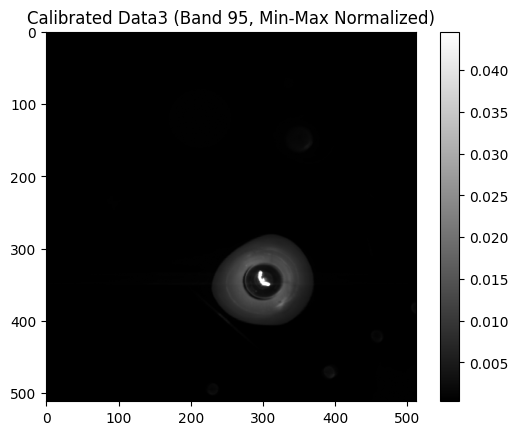

In [ ]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from spectral import envi

# Load the hyperspectral image and reference images
SCraw = envi.open('1875.hdr', '1875.raw')

# Open the white and dark reference images
white_reference = envi.open('WHITEREF_1875.hdr', image='WHITEREF_1875.raw')
dark_reference = envi.open('DARKREF_1875.hdr', image='DARKREF_1875.raw')

# Read the raw data and references as NumPy arrays
raw_data = SCraw.load()
white_data = white_reference.load()
dark_data = dark_reference.load()

# Subtract dark reference from raw image
calibrated_data3 = raw_data - dark_data

# Subtract dark reference from white reference
normalized_white = white_data - dark_data

# Divide calibrated image by normalized white reference
calibrated_data3 /= normalized_white

# Apply Savitzky-Golay filter along the spectral dimension
# Ensure the data has shape (height, width, bands)
bands = calibrated_data3.shape[-1]
for i in range(calibrated_data3.shape[0]):  # Iterate over height
    for j in range(calibrated_data3.shape[1]):  # Iterate over width
        calibrated_data3[i, j, :] = savgol_filter(
            calibrated_data3[i, j, :], window_length=11, polyorder=2
        )

# Apply Min-Max normalization to scale data between 0 and 1
calibrated_data_min = np.min(calibrated_data3)
calibrated_data_max = np.max(calibrated_data3)
calibrated_data3 = (calibrated_data3 - calibrated_data_min) / (calibrated_data_max - calibrated_data_min)

# Visualize an example band after normalization
plt.imshow(calibrated_data3[:, :, 95], cmap='gray')  # Example for the 50th band
plt.colorbar()
plt.title("Calibrated Data3 (Band 95, Min-Max Normalized)")
plt.show()


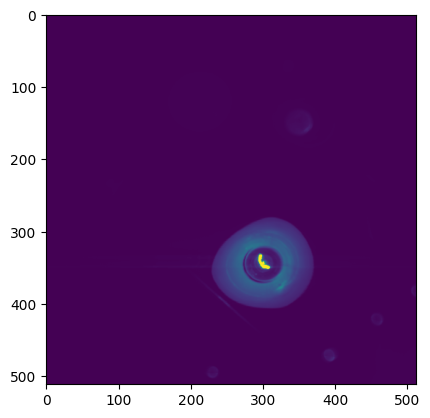

In [ ]:
plt.imshow(calibrated_data3[:,:,95])

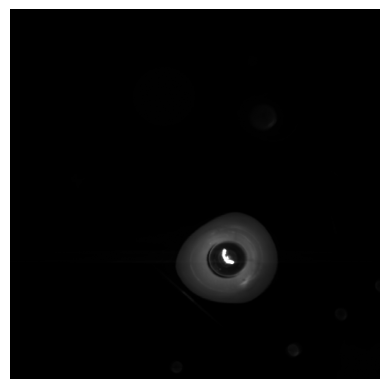

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Assuming calibrated_data3 is your hyperspectral dataset
# Extract the 95th band
band_95 = calibrated_data3[:, :, 95]

# Normalize the band for better visualization
band_95_normalized = (band_95 - band_95.min()) / (band_95.max() - band_95.min())

# Save the normalized band as a PNG
plt.imsave('band_95.png', band_95_normalized, cmap=cm.gray)

# Optional: Display the saved band
plt.imshow(band_95_normalized, cmap='gray')
plt.axis('off')
plt.show()


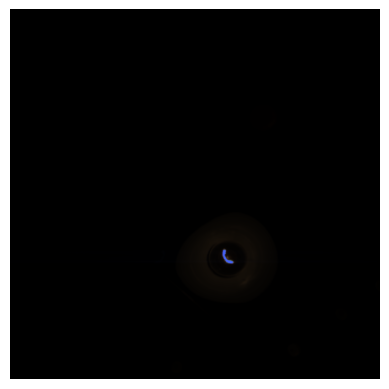

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming calibrated_data3 is your hyperspectral dataset
# Select bands for Red, Green, and Blue channels
red_band = calibrated_data3[:, :, 60]   # Replace 60 with the appropriate band index for red
green_band = calibrated_data3[:, :, 30] # Replace 30 with the appropriate band index for green
blue_band = calibrated_data3[:, :, 10]  # Replace 10 with the appropriate band index for blue

# Stack the selected bands to form an RGB image
rgb_image = np.dstack((red_band, green_band, blue_band))

# Normalize each channel to the [0, 1] range for visualization
rgb_image_normalized = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Save the RGB image
plt.imsave('rgb_image.png', rgb_image_normalized)

# Optional: Display the RGB image
plt.imshow(rgb_image_normalized)
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import json
import cv2

# Load the JSON file with annotations
with open('/content/labels_my-project-name_2024-11-18-01-28-26.json', 'r') as file:
    data = json.load(file)

# Initialize a blank mask with the same dimensions as the hyperspectral image
height, width = 512, 512  # Dimensions of the image
mask = np.zeros((height, width), dtype=np.uint8)

# Define the mapping of category names to label values
label_map = {'gold': 1, 'silver': 2, 'copper': 3}

# Loop through annotations to apply labels to the mask
for annotation in data['annotations']:
    category_id = annotation['category_id']
    segmentation = annotation['segmentation'][0]  # Use the first segmentation for this annotation

    # Reshape segmentation list into (x, y) coordinates
    points = np.array(segmentation).reshape(-1, 2)
    points = points.astype(np.int32)  # Convert to integer coordinates

    # Get the category name from the category_id
    category_name = next(cat['name'] for cat in data['categories'] if cat['id'] == category_id)

    # Fill the polygon on the mask
    cv2.fillPoly(mask, [points], label_map[category_name])

# Save the mask as a PNG
cv2.imwrite('label_mask3.png', mask)

print("Mask saved as label_mask3.png")


Mask saved as label_mask3.png


In [ ]:
import numpy as np
import cv2

# Load the saved label mask
mask = cv2.imread('label_mask3.png', cv2.IMREAD_GRAYSCALE)

# Define label-to-color mapping (assign distinct colors to each label)
label_colors = {
    0: (255, 255, 255),  # Background - White
    1: (255, 0, 0),      # Gold - Red
    2: (0, 255, 0),      # Silver - Green
    3: (0, 0, 255)       # Copper - Blue
}

# Create a blank RGB image with the same dimensions as the mask
height, width = mask.shape
colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

# Apply the colors to the mask based on label values
for label, color in label_colors.items():
    colored_mask[mask == label] = color

# Save the colored mask as a PNG image
cv2.imwrite('colored_label_mask3.png', colored_mask)

print("Colored mask saved as colored_label_mask3.png")


Colored mask saved as colored_label_mask3.png


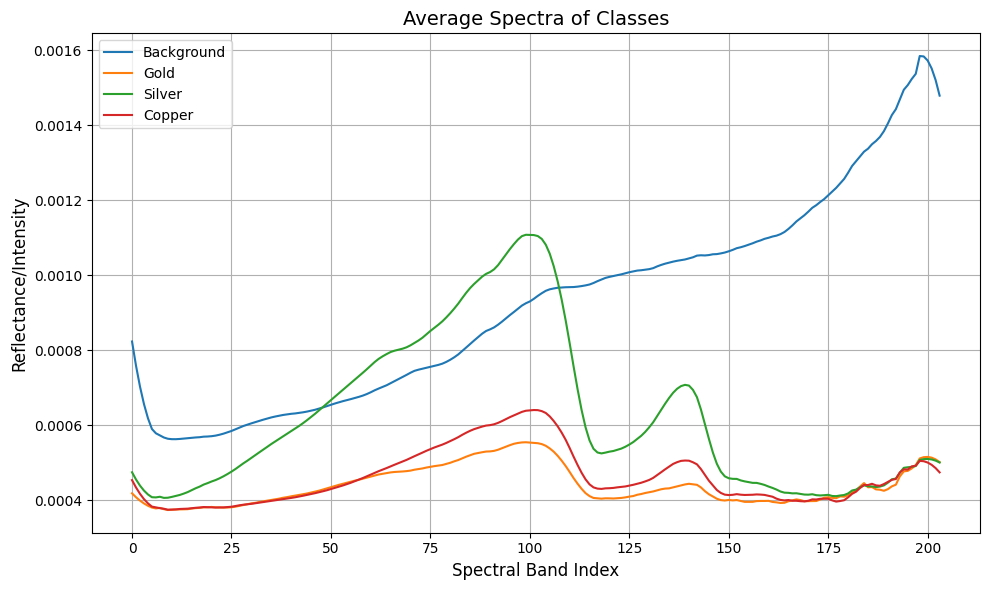

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the hyperspectral data (replace with actual data loading)
#calibrated_data2 = np.random.rand(512, 512, 204)  # Example: 512x512 image with 204 spectral bands

# Load the label mask
mask = cv2.imread('label_mask3.png', cv2.IMREAD_GRAYSCALE)

# Define the labels
labels = {
    0: 'Background',
    1: 'Gold',
    2: 'Silver',
    3: 'Copper'
}

# Initialize a dictionary to store average spectra for each class
average_spectra4 = {}

# Loop through each class and calculate the average spectra
for label in labels.keys():
    # Extract the pixels corresponding to the current label
    class_pixels = calibrated_data3[mask == label]

    if class_pixels.size > 0:  # Ensure there are pixels for this class
        # Calculate the mean spectrum for the class
        avg_spectrum = np.mean(class_pixels, axis=0)
        average_spectra4[label] = avg_spectrum
    else:
        average_spectra4[label] = None  # Handle empty classes gracefully

# Plot the average spectra
plt.figure(figsize=(10, 6))
for label, spectrum in average_spectra4.items():
    if spectrum is not None:
        plt.plot(spectrum, label=labels[label])  # Plot spectrum with corresponding label

# Customize the plot
plt.title("Average Spectra of Classes", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Reflectance/Intensity", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


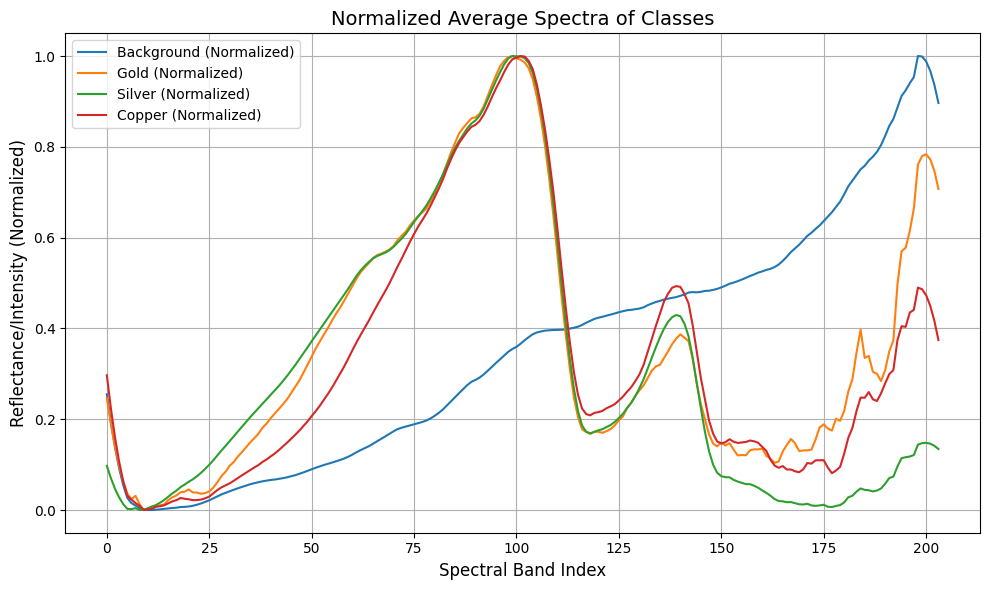

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the hyperspectral data (replace with actual data loading)
# calibrated_data3 is assumed to be available
mask = cv2.imread('label_mask3.png', cv2.IMREAD_GRAYSCALE)

# Define the labels
labels = {
    0: 'Background',
    1: 'Gold',
    2: 'Silver',
    3: 'Copper'
}

# Initialize a dictionary to store average spectra for each class
average_spectra4 = {}

# Loop through each class and calculate the average spectra
for label in labels.keys():
    # Extract the pixels corresponding to the current label
    class_pixels = calibrated_data3[mask == label]

    if class_pixels.size > 0:  # Ensure there are pixels for this class
        # Calculate the mean spectrum for the class
        avg_spectrum = np.mean(class_pixels, axis=0)
        average_spectra4[label] = avg_spectrum
    else:
        average_spectra4[label] = None  # Handle empty classes gracefully

# Normalize each spectrum (0 to 1)
def normalize_spectrum(spectrum):
    spectrum_min = np.min(spectrum)
    spectrum_max = np.max(spectrum)
    return (spectrum - spectrum_min) / (spectrum_max - spectrum_min)

# Apply normalization
normalized_spectra4 = {
    label: normalize_spectrum(spectrum) if spectrum is not None else None
    for label, spectrum in average_spectra4.items()
}

# Plot the normalized spectra
plt.figure(figsize=(10, 6))
for label, spectrum in normalized_spectra4.items():
    if spectrum is not None:
        plt.plot(spectrum, label=f"{labels[label]} (Normalized)")

# Customize the plot
plt.title("Normalized Average Spectra of Classes", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Reflectance/Intensity (Normalized)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()



Processing Gold (Label 1)
Visualizing results for Gold (Label 1):


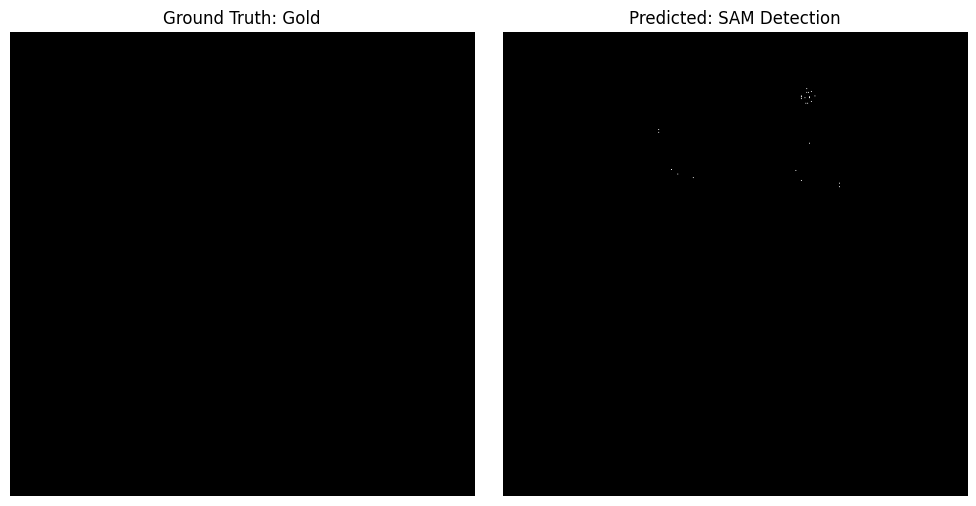

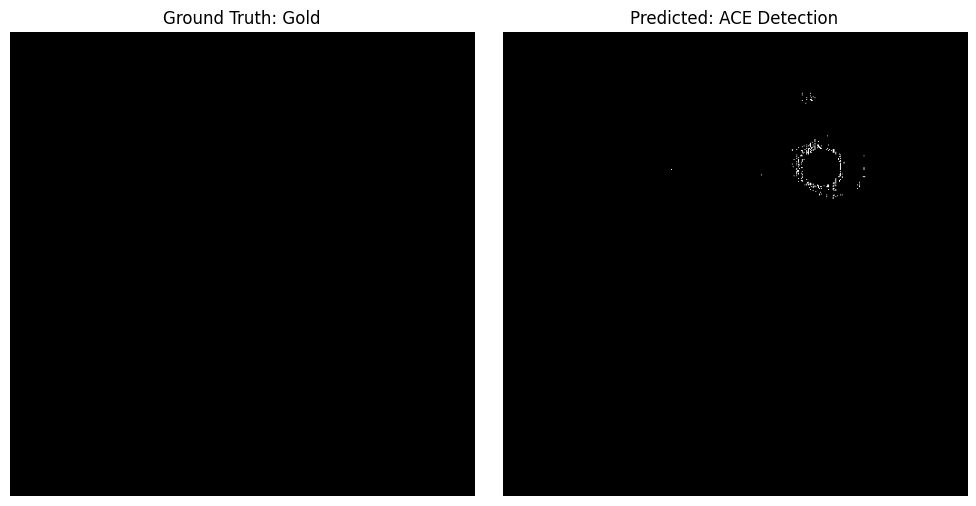

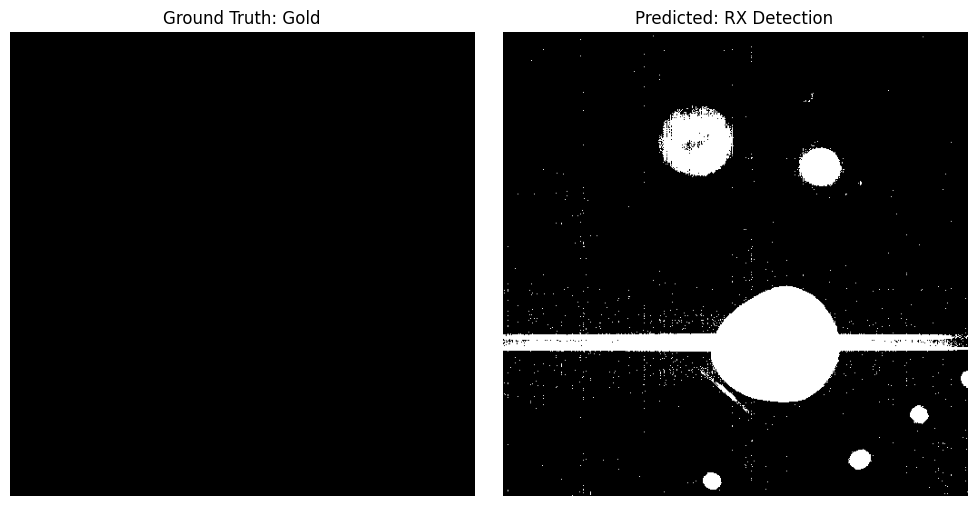


Processing Silver (Label 2)
Visualizing results for Silver (Label 2):


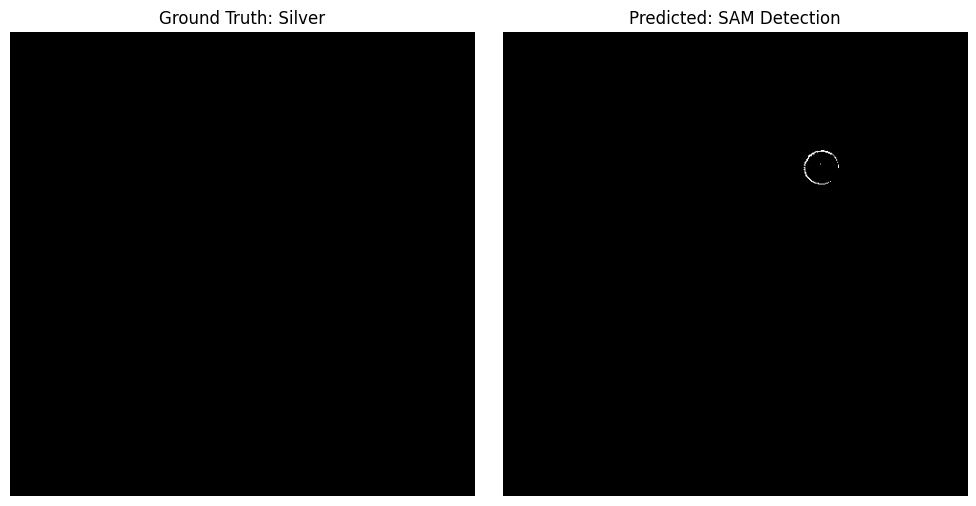

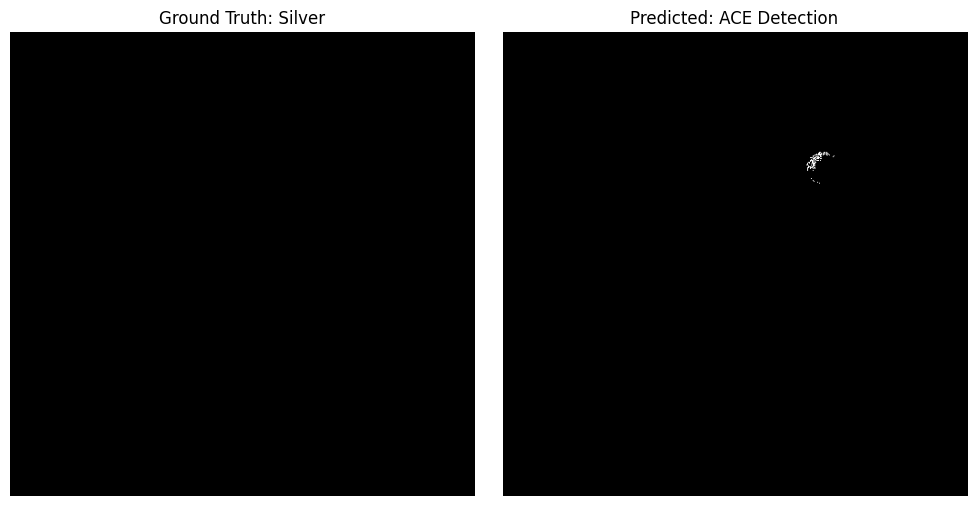

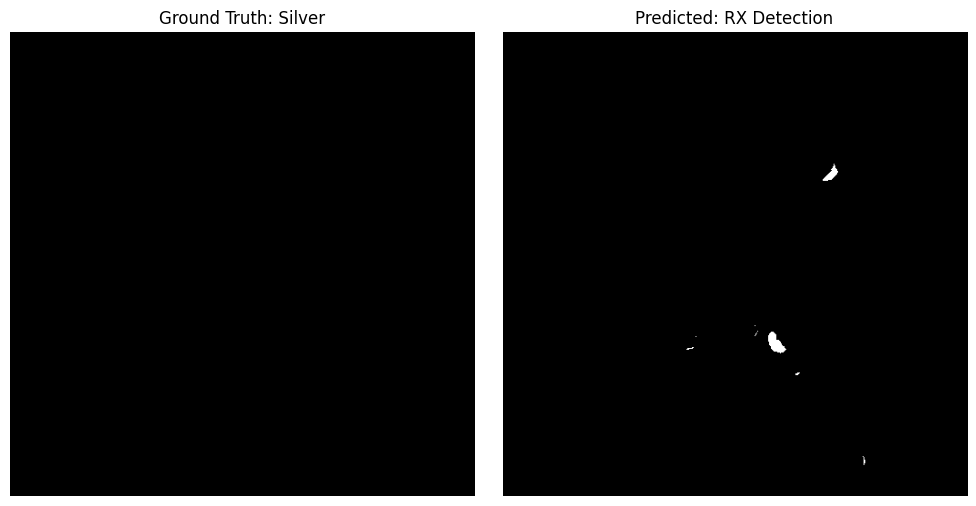


Processing Copper (Label 3)
Visualizing results for Copper (Label 3):


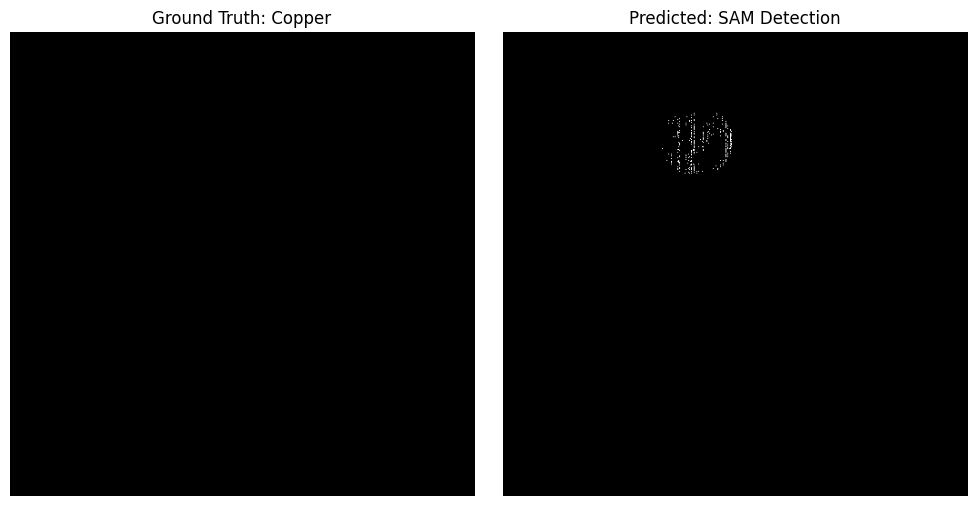

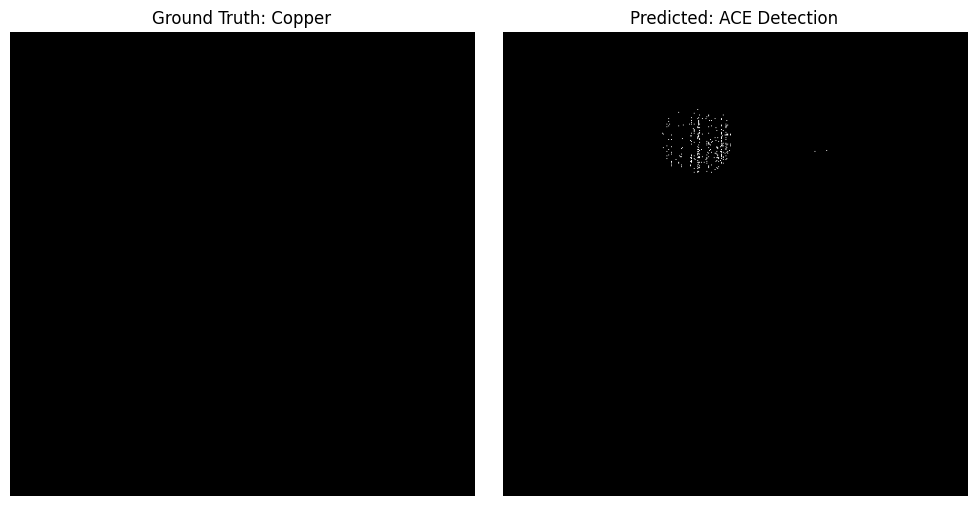

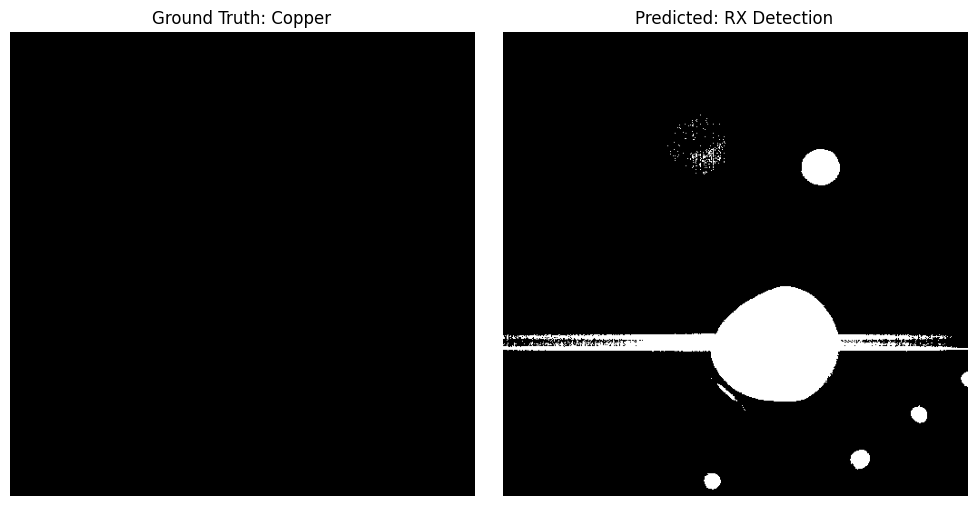


Results for Gold:
  SAM Metrics: Precision=0.5833, Recall=0.0524, F1-Score=0.0962, Accuracy=0.9990
  ACE Metrics: Precision=0.0479, Recall=0.0524, F1-Score=0.0501, Accuracy=0.9980
  RX Metrics: Precision=0.0005, Recall=0.0524, F1-Score=0.0010, Accuracy=0.8898

Results for Silver:
  SAM Metrics: Precision=0.9924, Recall=0.0501, F1-Score=0.0953, Accuracy=0.9906
  ACE Metrics: Precision=1.0000, Recall=0.0501, F1-Score=0.0954, Accuracy=0.9906
  RX Metrics: Precision=0.3030, Recall=0.0501, F1-Score=0.0860, Accuracy=0.9895

Results for Copper:
  SAM Metrics: Precision=1.0000, Recall=0.0501, F1-Score=0.0954, Accuracy=0.9792
  ACE Metrics: Precision=0.9931, Recall=0.0501, F1-Score=0.0954, Accuracy=0.9792
  RX Metrics: Precision=0.0136, Recall=0.0501, F1-Score=0.0213, Accuracy=0.8996


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from spectral import *
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming 'calibrated_data1' and 'label_mask1' are loaded
# 1. Spectral Angle Mapper (SAM)
def spectral_angle_mapper(image, target_spectrum):
    H, W, B = image.shape
    target_norm = np.linalg.norm(target_spectrum)
    sam_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel_spectrum = image[i, j, :]
            pixel_norm = np.linalg.norm(pixel_spectrum)
            angle = np.arccos(
                np.dot(pixel_spectrum, target_spectrum) / (pixel_norm * target_norm + 1e-8)
            )
            sam_map[i, j] = angle
    return sam_map

# 2. Adaptive Cosine Estimator (ACE)
def adaptive_cosine_estimator(image, target_spectrum):
    H, W, B = image.shape
    target_cov = np.cov(image.reshape(-1, B), rowvar=False)
    target_cov_inv = np.linalg.inv(target_cov + 1e-8 * np.eye(B))
    target_spectrum = target_spectrum.reshape(-1, 1)
    ace_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel_spectrum = image[i, j, :].reshape(-1, 1)
            numerator = np.dot(target_spectrum.T, np.dot(target_cov_inv, pixel_spectrum))
            denominator = (
                np.sqrt(np.dot(target_spectrum.T, np.dot(target_cov_inv, target_spectrum)))
                * np.sqrt(np.dot(pixel_spectrum.T, np.dot(target_cov_inv, pixel_spectrum)))
            )
            ace_map[i, j] = (numerator / (denominator + 1e-8)).item()
    return ace_map

# 3. RX Anomaly Detection
def rx_anomaly_detection(image):
    H, W, B = image.shape
    image_flat = image.reshape(-1, B)
    mean_vector = np.mean(image_flat, axis=0)
    cov_matrix = np.cov(image_flat, rowvar=False)
    cov_inv = np.linalg.inv(cov_matrix + 1e-8 * np.eye(B))
    rx_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            pixel = image[i, j, :]
            diff = pixel - mean_vector
            rx_map[i, j] = np.dot(diff.T, np.dot(cov_inv, diff))
    return rx_map

# Performance Metrics
def calculate_metrics(binary_result, ground_truth, average='macro'):
    binary_result_flat = binary_result.flatten()
    ground_truth_flat = ground_truth.flatten()

    precision = precision_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    recall = recall_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    f1 = f1_score(ground_truth_flat, binary_result_flat, average=average, zero_division=0)
    accuracy = accuracy_score(ground_truth_flat, binary_result_flat)

    return precision, recall, f1, accuracy

# Visualization of ground truth and predictions
def visualize_results(mask, binary_result, title, label_name):
    plt.figure(figsize=(10, 5))

    # Ground Truth
    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Ground Truth: {label_name}", fontsize=12)
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(binary_result, cmap='gray')
    plt.title(f"Predicted: {title}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Detect and evaluate for each target class in the second HSI image
labels = {1: 'Gold', 2: 'Silver', 3: 'Copper'}
results = {}

for label, name in labels.items():
    print(f"\nProcessing {name} (Label {label})")

    mask_grayscale = cv2.imread('label_mask3.png', cv2.IMREAD_GRAYSCALE)
    target_spectrum = np.mean(calibrated_data3[mask_grayscale == label], axis=0)

    # Detection maps
    sam_result = spectral_angle_mapper(calibrated_data3, target_spectrum)
    ace_result = adaptive_cosine_estimator(calibrated_data3, target_spectrum)
    rx_result = rx_anomaly_detection(calibrated_data3)

    # Convert to binary maps for the current target
    sam_binary = (sam_result < np.percentile(sam_result[mask_grayscale == label], 5)).astype(int)  # Smallest 5% angles
    ace_binary = (ace_result > np.percentile(ace_result[mask_grayscale == label], 95)).astype(int)  # Top 5% ACE scores
    rx_binary = (rx_result > np.percentile(rx_result[mask_grayscale == label], 95)).astype(int)  # Top 5% anomalies

    # Evaluate performance
    sam_metrics = calculate_metrics(sam_binary, (mask_grayscale == label).astype(int), average='binary')
    ace_metrics = calculate_metrics(ace_binary, (mask_grayscale == label).astype(int), average='binary')
    rx_metrics = calculate_metrics(rx_binary, (mask_grayscale == label).astype(int), average='binary')

    # Store results
    results[name] = {
        "SAM Metrics": sam_metrics,
        "ACE Metrics": ace_metrics,
        "RX Metrics": rx_metrics,
    }

    # Visualize results
    print(f"Visualizing results for {name} (Label {label}):")
    visualize_results((label_mask1 == label).astype(int), sam_binary, "SAM Detection", name)
    visualize_results((label_mask1 == label).astype(int), ace_binary, "ACE Detection", name)
    visualize_results((label_mask1 == label).astype(int), rx_binary, "RX Detection", name)

# Display Results
for target, metrics in results.items():
    print(f"\nResults for {target}:")
    for method, values in metrics.items():
        print(f"  {method}: Precision={values[0]:.4f}, Recall={values[1]:.4f}, F1-Score={values[2]:.4f}, Accuracy={values[3]:.4f}")


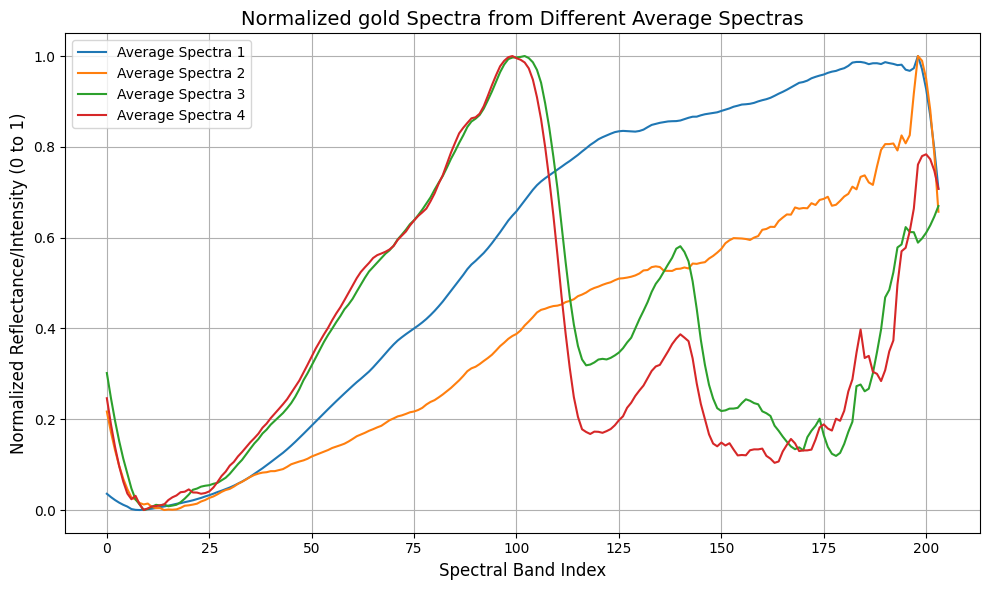

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to normalize a spectrum to [0, 1]
def normalize_spectrum(spectrum):
    if spectrum is not None:
        min_val = np.min(spectrum)
        max_val = np.max(spectrum)
        return (spectrum - min_val) / (max_val - min_val)
    else:
        return None

# Collect and normalize "Background" spectra
gold_spectra = {
    "Average Spectra 1": normalize_spectrum(average_spectra1[1]),
    "Average Spectra 2": normalize_spectrum(average_spectra2[1]),
    "Average Spectra 3": normalize_spectrum(average_spectra3[1]),
    "Average Spectra 4": normalize_spectrum(average_spectra4[1]),
}

# Check if all Background spectra are available
for key, spectrum in gold_spectra.items():
    if spectrum is None:
        print(f"{key}: gold spectrum is not available.")

# Plot the normalized Background spectra
plt.figure(figsize=(10, 6))
for label, spectrum in gold_spectra.items():
    if spectrum is not None:
        plt.plot(spectrum, label=label)

# Customize the plot
plt.title("Normalized gold Spectra from Different Average Spectras", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Normalized Reflectance/Intensity (0 to 1)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


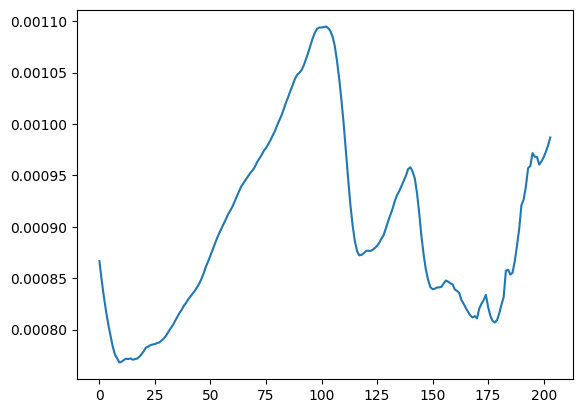

In [ ]:
plt.plot(average_spectra3.get(1))

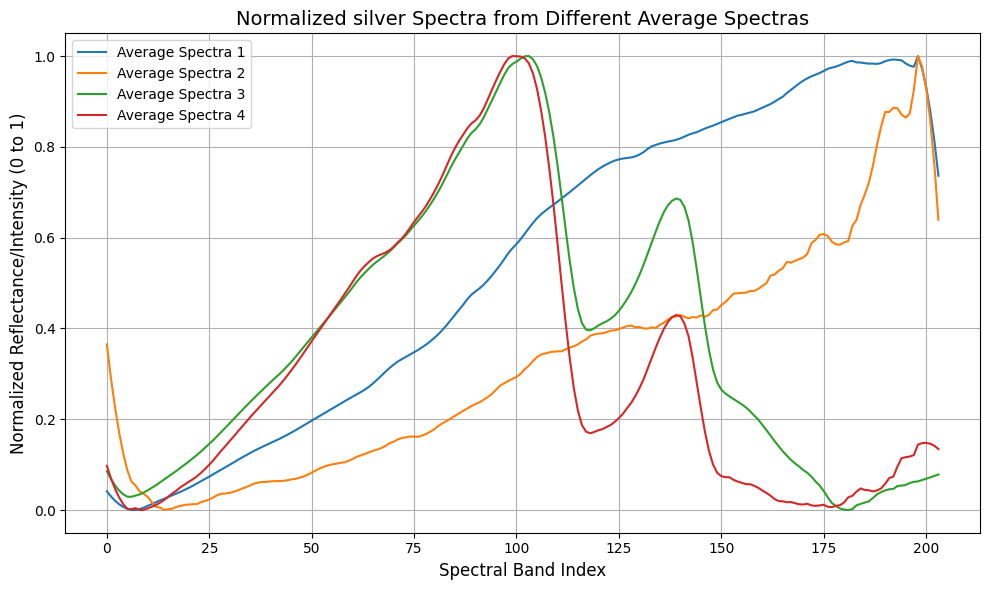

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to normalize a spectrum to [0, 1]
def normalize_spectrum(spectrum):
    if spectrum is not None:
        min_val = np.min(spectrum)
        max_val = np.max(spectrum)
        return (spectrum - min_val) / (max_val - min_val)
    else:
        return None

# Collect and normalize "Background" spectra
silver_spectra = {
    "Average Spectra 1": normalize_spectrum(average_spectra1[2]),
    "Average Spectra 2": normalize_spectrum(average_spectra2[2]),
    "Average Spectra 3": normalize_spectrum(average_spectra3[2]),
    "Average Spectra 4": normalize_spectrum(average_spectra4[2]),
}

# Check if all Background spectra are available
for key, spectrum in silver_spectra.items():
    if spectrum is None:
        print(f"{key}: silver spectrum is not available.")

# Plot the normalized Background spectra
plt.figure(figsize=(10, 6))
for label, spectrum in silver_spectra.items():
    if spectrum is not None:
        plt.plot(spectrum, label=label)

# Customize the plot
plt.title("Normalized silver Spectra from Different Average Spectras", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Normalized Reflectance/Intensity (0 to 1)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


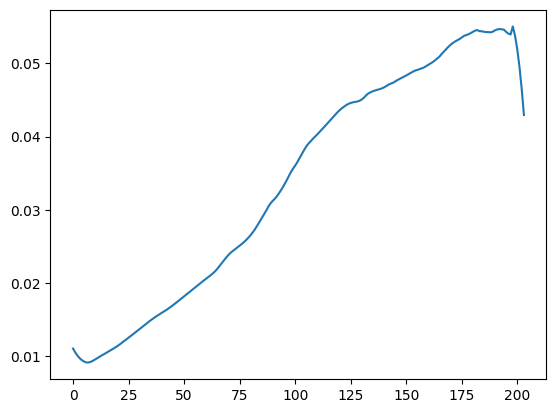

In [ ]:
plt.plot(average_spectra1.get(2))

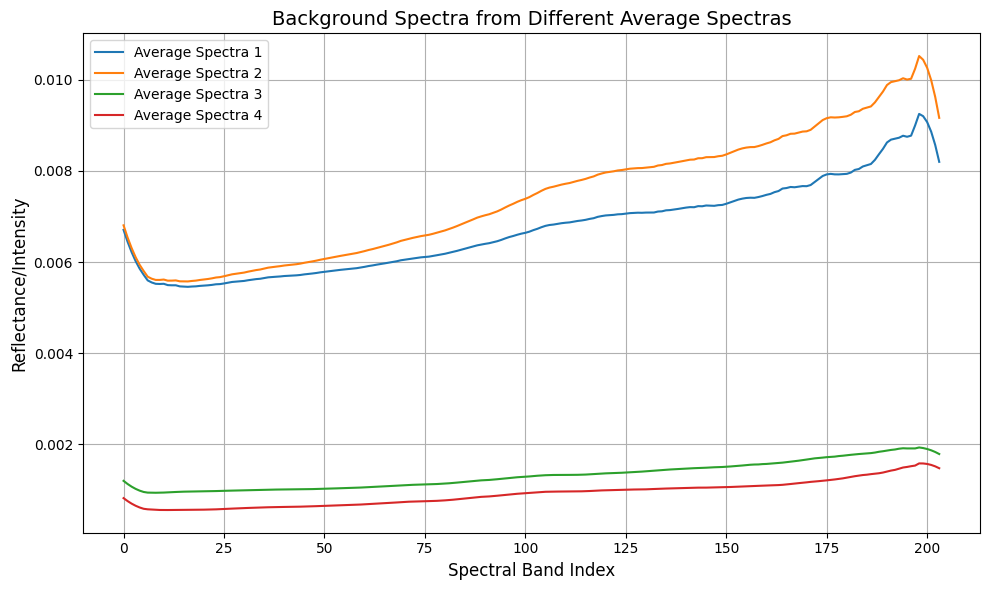

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all "Background" spectra
background_spectra = {
    "Average Spectra 1": average_spectra1[0],
    "Average Spectra 2": average_spectra2[0],
    "Average Spectra 3": average_spectra3[0],
    "Average Spectra 4": average_spectra4[0],
}

# Check if all Background spectra are available
for key, spectrum in background_spectra.items():
    if spectrum is None:
        print(f"{key}: Background spectrum is not available.")

# Plot the Background spectra
plt.figure(figsize=(10, 6))
for label, spectrum in background_spectra.items():
    if spectrum is not None:
        plt.plot(spectrum, label=label)

# Customize the plot
plt.title("Background Spectra from Different Average Spectras", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Reflectance/Intensity", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


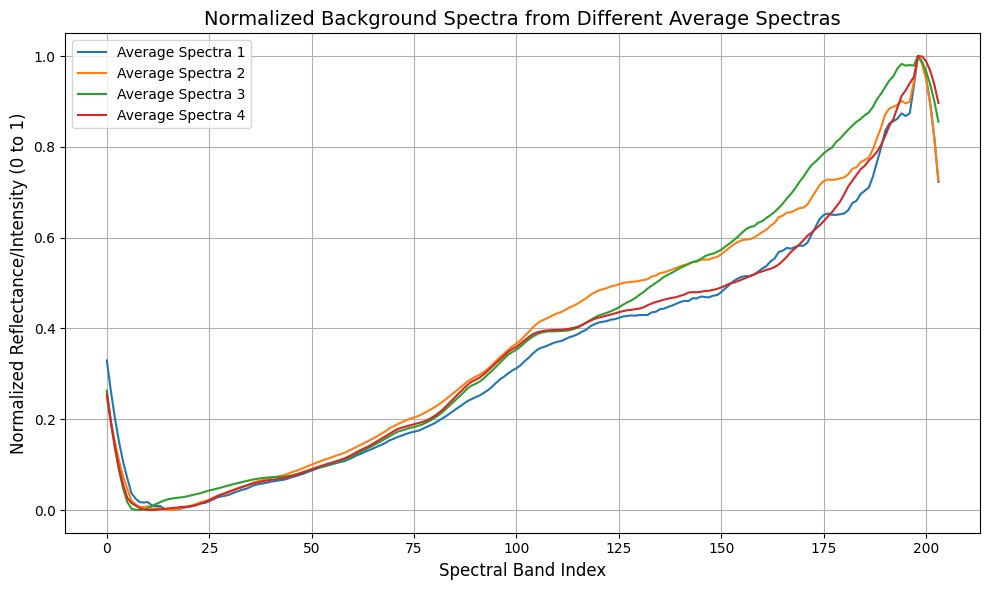

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to normalize a spectrum to [0, 1]
def normalize_spectrum(spectrum):
    if spectrum is not None:
        min_val = np.min(spectrum)
        max_val = np.max(spectrum)
        return (spectrum - min_val) / (max_val - min_val)
    else:
        return None

# Collect and normalize "Background" spectra
background_spectra = {
    "Average Spectra 1": normalize_spectrum(average_spectra1[0]),
    "Average Spectra 2": normalize_spectrum(average_spectra2[0]),
    "Average Spectra 3": normalize_spectrum(average_spectra3[0]),
    "Average Spectra 4": normalize_spectrum(average_spectra4[0]),
}

# Check if all Background spectra are available
for key, spectrum in background_spectra.items():
    if spectrum is None:
        print(f"{key}: Background spectrum is not available.")

# Plot the normalized Background spectra
plt.figure(figsize=(10, 6))
for label, spectrum in background_spectra.items():
    if spectrum is not None:
        plt.plot(spectrum, label=label)

# Customize the plot
plt.title("Normalized Background Spectra from Different Average Spectras", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Normalized Reflectance/Intensity (0 to 1)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


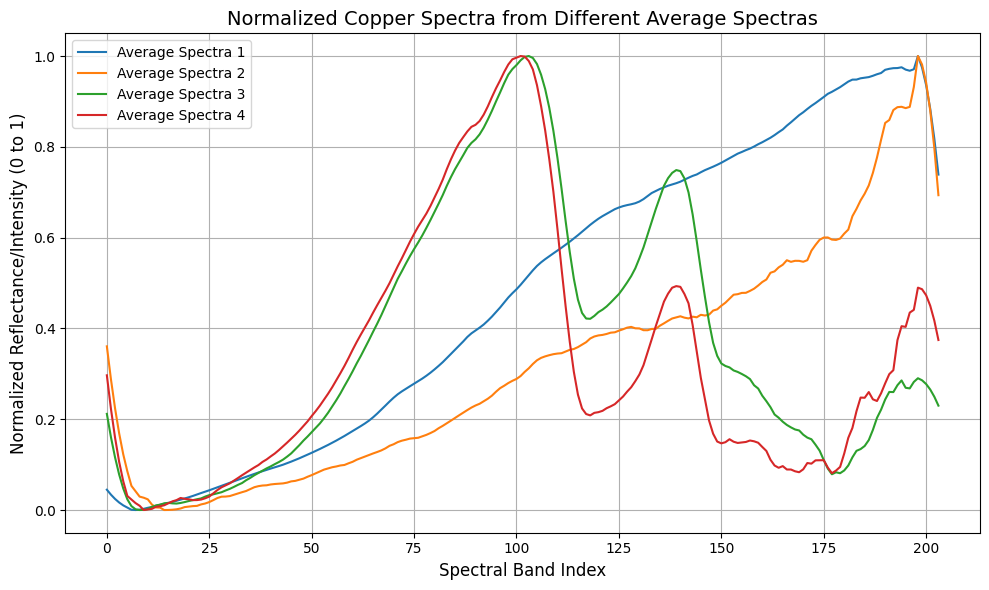

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to normalize a spectrum to the range [0, 1]
def normalize_spectrum(spectrum):
    min_val = np.min(spectrum)
    max_val = np.max(spectrum)
    if max_val - min_val == 0:
        return spectrum  # Avoid division by zero if spectrum is constant
    return (spectrum - min_val) / (max_val - min_val)

# Extract "Copper" (label 3) spectra and normalize
copper_spectra = {
    "Average Spectra 1": normalize_spectrum(average_spectra1[3]) if average_spectra1[3] is not None else None,
    "Average Spectra 2": normalize_spectrum(average_spectra2[3]) if average_spectra2[3] is not None else None,
    "Average Spectra 3": normalize_spectrum(average_spectra3[3]) if average_spectra3[3] is not None else None,
    "Average Spectra 4": normalize_spectrum(average_spectra4[3]) if average_spectra4[3] is not None else None,
}

# Check if Copper spectra are available
for key, spectrum in copper_spectra.items():
    if spectrum is None:
        print(f"{key}: Copper spectrum is not available.")

# Plot the normalized Copper spectra
plt.figure(figsize=(10, 6))
for label, spectrum in copper_spectra.items():
    if spectrum is not None:
        plt.plot(spectrum, label=label)

# Customize the plot
plt.title("Normalized Copper Spectra from Different Average Spectras", fontsize=14)
plt.xlabel("Spectral Band Index", fontsize=12)
plt.ylabel("Normalized Reflectance/Intensity (0 to 1)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Function to apply augmentations
def augment_spectra(spectrum, num_augments=4):
    augmented_data = []

    for _ in range(num_augments):
        if spectrum is not None:
            # Spectral shift
            shift = np.random.uniform(-0.01, 0.01, size=spectrum.shape)
            shifted_spectrum = spectrum + shift

            # Spectral scaling
            scale = np.random.uniform(0.9, 1.1)
            scaled_spectrum = shifted_spectrum * scale

            # Add Gaussian noise
            noise = np.random.normal(0, 0.005, size=spectrum.shape)
            noisy_spectrum = scaled_spectrum + noise

            # Spectral band removal (set random bands to zero)
            mask = np.random.choice([0, 1], size=spectrum.shape, p=[0.1, 0.9])  # 10% bands removed
            augmented_spectrum = noisy_spectrum * mask

            # Normalize the augmented spectrum
            augmented_spectrum = normalize_spectrum(augmented_spectrum)
            augmented_data.append(augmented_spectrum)

    return augmented_data

# Augment and organize data
def augment_and_organize_data(label_spectra, label_name):
    augmented_spectra = {}
    for key, spectrum in label_spectra.items():
        if spectrum is not None:
            augmented_spectra[key] = augment_spectra(spectrum)
        else:
            print(f"{key}: {label_name} spectrum is not available.")
    return augmented_spectra

# Augment data for all labels
background_augmented = augment_and_organize_data(background_spectra, "Background")
gold_augmented = augment_and_organize_data(gold_spectra, "Gold")
silver_augmented = augment_and_organize_data(silver_spectra, "Silver")
copper_augmented = augment_and_organize_data(copper_spectra, "Copper")
